### Importing Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import warnings

#Spotipy
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

#Data Cleaning
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.impute import KNNImputer
from sklearn.preprocessing import PowerTransformer

#Modelling
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import metrics

#Clustering
import plotly.express as px 
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from PIL import Image
from yellowbrick.cluster import SilhouetteVisualizer

#Recommendation system
from collections import defaultdict
from sklearn.metrics import euclidean_distances
from scipy.spatial.distance import cdist
import difflib

plt.style.use('fivethirtyeight')
%matplotlib inline
warnings.filterwarnings('ignore')
sns.set_palette('rainbow')
sns.set_style('whitegrid')

In [186]:
!pip install pyspark

  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=8b2454e01ed469b389d827493037d87eaf4e092661cdd0963e2e763d9fda0d79
  Stored in directory: c:\users\rshara4\appdata\local\pip\cache\wheels\51\c8\18\298a4ced8ebb3ab8a7d26a7198c0cc7035abb906bde94a4c4b
Successfully built pyspark


In [187]:
!pip install -U -q PyDrive

In [194]:
!apt install openjdk-8-jdk-headless -qq

'apt' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
import pyspark
from pyspark import SparkContext, SQLContext

### Data Extraction

In [3]:
#Reading spotify login credentials from Spotify developer's id
id_df = pd.read_csv('Spotify_id.txt')

In [4]:
#Authentication - without user credentials
cid = id_df.iloc[0,0]
secret = id_df.iloc[1,0]
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

In [5]:
#Extracting top 50 songs playlist to check functionality
playlist_link = "https://open.spotify.com/playlist/37i9dQZEVXbNG2KDcFcKOF?si=1333723a6eff4b7f"
playlist_URI = playlist_link.split("/")[-1].split("?")[0]
track_uris = [x["track"]["uri"] for x in sp.playlist_tracks(playlist_URI)["items"]]

In [6]:
track_uris

['spotify:track:3nqQXoyQOWXiESFLlDF1hG',
 'spotify:track:0V3wPSX9ygBnCm8psDIegu',
 'spotify:track:1bDbXMyjaUIooNwFE9wn0N',
 'spotify:track:5ww2BF9slyYgNOk37BlC4u',
 'spotify:track:4uUG5RXrOk84mYEfFvj3cK',
 'spotify:track:4Dvkj6JhhA12EX05fT7y2e',
 'spotify:track:2tTmW7RDtMQtBk7m2rYeSw',
 'spotify:track:0QHEIqNKsMoOY5urbzN48u',
 'spotify:track:5IgjP7X4th6nMNDh4akUHb',
 'spotify:track:6Sq7ltF9Qa7SNFBsV5Cogx',
 'spotify:track:73vIOb4Q7YN6HeJTbscRx5',
 'spotify:track:4h9wh7iOZ0GGn8QVp4RAOB',
 'spotify:track:1IHWl5LamUGEuP4ozKQSXZ',
 'spotify:track:1zsPaEkglFvxjAhrM8yhpr',
 'spotify:track:7jtQIBanIiJOMS6RyCx6jZ',
 'spotify:track:1RDvyOk4WtPCtoqciJwVn8',
 'spotify:track:7MkylDYvKTSuWgrsBhHlsG',
 'spotify:track:0bYg9bo50gSsH3LtXe2SQn',
 'spotify:track:4k6Uh1HXdhtusDW5y8Gbvy',
 'spotify:track:53tfEupEzQRtVFOeZvk7xq',
 'spotify:track:3rWDp9tBPQR9z6U5YyRSK4',
 'spotify:track:5jQI2r1RdgtuT8S3iG8zFC',
 'spotify:track:6VhuP99TE6gYNQRJIlAWFD',
 'spotify:track:5Eax0qFko2dh7Rl2lYs3bx',
 'spotify:track:

In [8]:
#Retreiving audio_feature of a track using 'sp' object
sp.audio_features(track_uris)[0]

{'danceability': 0.714,
 'energy': 0.472,
 'key': 2,
 'loudness': -7.375,
 'mode': 1,
 'speechiness': 0.0864,
 'acousticness': 0.013,
 'instrumentalness': 4.51e-06,
 'liveness': 0.266,
 'valence': 0.238,
 'tempo': 131.121,
 'type': 'audio_features',
 'id': '3nqQXoyQOWXiESFLlDF1hG',
 'uri': 'spotify:track:3nqQXoyQOWXiESFLlDF1hG',
 'track_href': 'https://api.spotify.com/v1/tracks/3nqQXoyQOWXiESFLlDF1hG',
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/3nqQXoyQOWXiESFLlDF1hG',
 'duration_ms': 156943,
 'time_signature': 4}

In [9]:
#Retreiving Various needed details of a track
for track in sp.playlist_tracks(playlist_URI)["items"]:
    #URI
    track_uri = track["track"]["uri"]
    
    #Track name
    track_name = track["track"]["name"]
    
    #Main Artist
    artist_uri = track["track"]["artists"][0]["uri"]
    artist_info = sp.artist(artist_uri)
    
    #Name, popularity, genre
    artist_name = track["track"]["artists"][0]["name"]
    artist_pop = artist_info["popularity"]
    artist_genres = artist_info["genres"]
    
    #Album
    album = track["track"]["album"]["name"]
    
    #Popularity of the track
    track_pop = track["track"]["popularity"]

In [10]:
print('track_name:',track_name)
print('artist_name:',artist_name)
print('album:',album)
print('popularity score:',track_pop)

track_name: Rockin' Around The Christmas Tree
artist_name: Brenda Lee
album: Merry Christmas From Brenda Lee
popularity score: 86


In [11]:
#Displaying Genre of Artist
artist_genres

['adult standards', 'brill building pop']

In [20]:
#Reading Extracted first 1000 playlists
import json
data = json.load(open('C:\\Users\\rshara4\\Downloads\\spotify_million_playlist_dataset\\data\\mpd.slice.0-999.json'))

df1 = pd.DataFrame(data["playlists"])

In [21]:
df1

,name,collaborative,pid,modified_at,num_tracks,num_albums,num_followers,tracks,num_edits,duration_ms,num_artists,description
0,Throwbacks,false,0,1493424000,52,47,1,"[{'pos': 0, 'artist_name': 'Missy Elliott', 't...",6,11532414,37,NaN
1,Awesome Playlist,false,1,1506556800,39,23,1,"[{'pos': 0, 'artist_name': 'Survivor', 'track_...",5,11656470,21,NaN
2,korean,false,2,1505692800,64,51,1,"[{'pos': 0, 'artist_name': 'Hoody', 'track_uri...",18,14039958,31,NaN
3,mat,false,3,1501027200,126,107,1,"[{'pos': 0, 'artist_name': 'Camille Saint-Saën...",4,28926058,86,NaN
4,90s,false,4,1401667200,17,16,2,"[{'pos': 0, 'artist_name': 'The Smashing Pumpk...",7,4335282,16,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
995,old,false,995,1507852800,41,40,1,"[{'pos': 0, 'artist_name': 'Katrina', 'track_u...",8,9917901,36,NaN
996,Daze,false,996,1479254400,17,17,1,"[{'pos': 0, 'artist_name': 'PARTYNEXTDOOR', 't...",13,3699248,15,NaN
997,rap,false,997,1410307200,119,98,1,"[{'pos': 0, 'artist_name': 'LoveRance', 'track...",63,27538723,82,NaN
998,Country,false,998,1507939200,108,75,1,"[{'pos': 0, 'artist_name': 'Hunter Hayes', 'tr...",37,24950143,40,NaN


In [22]:
#Loading next 1k playlists
import json
# load data using Python JSON module
with open('C:\\Users\\rshara4\\Downloads\\spotify_million_playlist_dataset\\data\\mpd.slice.1000-1999.json','r') as f:
    data = json.loads(f.read())
    
# Normalizing data
df2 = pd.json_normalize(data, record_path=['playlists'])

In [23]:
df2

,name,collaborative,pid,modified_at,num_tracks,num_albums,num_followers,tracks,num_edits,duration_ms,num_artists,description
0,disney,false,1000,1457827200,189,16,1,"[{'pos': 0, 'artist_name': 'Original Broadway ...",4,31428282,65,NaN
1,Indie Electro,false,1001,1417824000,165,18,2,"[{'pos': 0, 'artist_name': 'The Octopus Projec...",2,38241566,8,NaN
2,jack & jack,false,1002,1465430400,17,14,1,"[{'pos': 0, 'artist_name': 'Jack & Jack', 'tra...",3,3549358,3,NaN
3,vibes,false,1003,1498435200,225,195,2,"[{'pos': 0, 'artist_name': 'LANY', 'track_uri'...",91,51242585,157,NaN
4,Indie,false,1004,1498608000,165,118,1,"[{'pos': 0, 'artist_name': 'Youth Lagoon', 'tr...",74,42601098,92,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
995,woo,false,1995,1509062400,146,68,2,"[{'pos': 0, 'artist_name': 'blink-182', 'track...",13,29183178,24,NaN
996,NEW YEARS,false,1996,1420070400,38,37,1,"[{'pos': 0, 'artist_name': 'Big Sean', 'track_...",3,9354755,34,NaN
997,JESUS,false,1997,1508371200,40,28,2,"[{'pos': 0, 'artist_name': 'Elevation Worship'...",8,10940019,22,NaN
998,yep,false,1998,1448236800,29,27,1,"[{'pos': 0, 'artist_name': 'Oasis', 'track_uri...",3,7260645,20,NaN


In [39]:
#Storing track details from dataframe into a list
playlist = df1['tracks']
playlist2 = df2['tracks']

In [19]:
#Displaying elements of the list
df['tracks'][0]

[{'pos': 0,
  'artist_name': 'Missy Elliott',
  'track_uri': 'spotify:track:0UaMYEvWZi0ZqiDOoHU3YI',
  'artist_uri': 'spotify:artist:2wIVse2owClT7go1WT98tk',
  'track_name': 'Lose Control (feat. Ciara & Fat Man Scoop)',
  'album_uri': 'spotify:album:6vV5UrXcfyQD1wu4Qo2I9K',
  'duration_ms': 226863,
  'album_name': 'The Cookbook'},
 {'pos': 1,
  'artist_name': 'Britney Spears',
  'track_uri': 'spotify:track:6I9VzXrHxO9rA9A5euc8Ak',
  'artist_uri': 'spotify:artist:26dSoYclwsYLMAKD3tpOr4',
  'track_name': 'Toxic',
  'album_uri': 'spotify:album:0z7pVBGOD7HCIB7S8eLkLI',
  'duration_ms': 198800,
  'album_name': 'In The Zone'},
 {'pos': 2,
  'artist_name': 'Beyoncé',
  'track_uri': 'spotify:track:0WqIKmW4BTrj3eJFmnCKMv',
  'artist_uri': 'spotify:artist:6vWDO969PvNqNYHIOW5v0m',
  'track_name': 'Crazy In Love',
  'album_uri': 'spotify:album:25hVFAxTlDvXbx2X2QkUkE',
  'duration_ms': 235933,
  'album_name': 'Dangerously In Love (Alben für die Ewigkeit)'},
 {'pos': 3,
  'artist_name': 'Justin Timb

In [43]:
#Generating skeleton of metadata Dataframe
meta = pd.DataFrame([[0,0,0,0,0,0,0,0]], columns=['pos','artist_name','track_uri','artist_uri','track_name','album_uri','duration_ms','album_name'])

In [44]:
#Generating Meta-data dataframe to store track's metedata
for i in playlist:
    tracks = len(i)
    for j in range(tracks):
        lst = []
        for k in meta.columns:
            lst.append(i[j][k])
        #print(lst)
        #meta = meta.append(pd.Series(lst, index=['pos','artist_name','track_uri','artist_uri','track_name','album_uri','duration_ms','album_name']), ignore_index=True)
        meta.loc[len(meta)] = lst

In [47]:
#Appending to metadata from playlists 1000-2000
for i in playlist2:
    tracks = len(i)
    for j in range(tracks):
        lst = []
        for k in meta.columns:
            lst.append(i[j][k])
        #print(lst)
        #meta = meta.append(pd.Series(lst, index=['pos','artist_name','track_uri','artist_uri','track_name','album_uri','duration_ms','album_name']), ignore_index=True)
        meta.loc[len(meta)] = lst
        print(len(meta))

67505
67506
67507
67508
67509
67510
67511
67512
67513
67514
67515
67516
67517
67518
67519
67520
67521
67522
67523
67524
67525
67526
67527
67528
67529
67530
67531
67532
67533
67534
67535
67536
67537
67538
67539
67540
67541
67542
67543
67544
67545
67546
67547
67548
67549
67550
67551
67552
67553
67554
67555
67556
67557
67558
67559
67560
67561
67562
67563
67564
67565
67566
67567
67568
67569
67570
67571
67572
67573
67574
67575
67576
67577
67578
67579
67580
67581
67582
67583
67584
67585
67586
67587
67588
67589
67590
67591
67592
67593
67594
67595
67596
67597
67598
67599
67600
67601
67602
67603
67604
67605
67606
67607
67608
67609
67610
67611
67612
67613
67614
67615
67616
67617
67618
67619
67620
67621
67622
67623
67624
67625
67626
67627
67628
67629
67630
67631
67632
67633
67634
67635
67636
67637
67638
67639
67640
67641
67642
67643
67644
67645
67646
67647
67648
67649
67650
67651
67652
67653
67654
67655
67656
67657
67658
67659
67660
67661
67662
67663
67664
67665
67666
67667
67668
67669
67670
6767

68871
68872
68873
68874
68875
68876
68877
68878
68879
68880
68881
68882
68883
68884
68885
68886
68887
68888
68889
68890
68891
68892
68893
68894
68895
68896
68897
68898
68899
68900
68901
68902
68903
68904
68905
68906
68907
68908
68909
68910
68911
68912
68913
68914
68915
68916
68917
68918
68919
68920
68921
68922
68923
68924
68925
68926
68927
68928
68929
68930
68931
68932
68933
68934
68935
68936
68937
68938
68939
68940
68941
68942
68943
68944
68945
68946
68947
68948
68949
68950
68951
68952
68953
68954
68955
68956
68957
68958
68959
68960
68961
68962
68963
68964
68965
68966
68967
68968
68969
68970
68971
68972
68973
68974
68975
68976
68977
68978
68979
68980
68981
68982
68983
68984
68985
68986
68987
68988
68989
68990
68991
68992
68993
68994
68995
68996
68997
68998
68999
69000
69001
69002
69003
69004
69005
69006
69007
69008
69009
69010
69011
69012
69013
69014
69015
69016
69017
69018
69019
69020
69021
69022
69023
69024
69025
69026
69027
69028
69029
69030
69031
69032
69033
69034
69035
69036
6903

70242
70243
70244
70245
70246
70247
70248
70249
70250
70251
70252
70253
70254
70255
70256
70257
70258
70259
70260
70261
70262
70263
70264
70265
70266
70267
70268
70269
70270
70271
70272
70273
70274
70275
70276
70277
70278
70279
70280
70281
70282
70283
70284
70285
70286
70287
70288
70289
70290
70291
70292
70293
70294
70295
70296
70297
70298
70299
70300
70301
70302
70303
70304
70305
70306
70307
70308
70309
70310
70311
70312
70313
70314
70315
70316
70317
70318
70319
70320
70321
70322
70323
70324
70325
70326
70327
70328
70329
70330
70331
70332
70333
70334
70335
70336
70337
70338
70339
70340
70341
70342
70343
70344
70345
70346
70347
70348
70349
70350
70351
70352
70353
70354
70355
70356
70357
70358
70359
70360
70361
70362
70363
70364
70365
70366
70367
70368
70369
70370
70371
70372
70373
70374
70375
70376
70377
70378
70379
70380
70381
70382
70383
70384
70385
70386
70387
70388
70389
70390
70391
70392
70393
70394
70395
70396
70397
70398
70399
70400
70401
70402
70403
70404
70405
70406
70407
7040

71611
71612
71613
71614
71615
71616
71617
71618
71619
71620
71621
71622
71623
71624
71625
71626
71627
71628
71629
71630
71631
71632
71633
71634
71635
71636
71637
71638
71639
71640
71641
71642
71643
71644
71645
71646
71647
71648
71649
71650
71651
71652
71653
71654
71655
71656
71657
71658
71659
71660
71661
71662
71663
71664
71665
71666
71667
71668
71669
71670
71671
71672
71673
71674
71675
71676
71677
71678
71679
71680
71681
71682
71683
71684
71685
71686
71687
71688
71689
71690
71691
71692
71693
71694
71695
71696
71697
71698
71699
71700
71701
71702
71703
71704
71705
71706
71707
71708
71709
71710
71711
71712
71713
71714
71715
71716
71717
71718
71719
71720
71721
71722
71723
71724
71725
71726
71727
71728
71729
71730
71731
71732
71733
71734
71735
71736
71737
71738
71739
71740
71741
71742
71743
71744
71745
71746
71747
71748
71749
71750
71751
71752
71753
71754
71755
71756
71757
71758
71759
71760
71761
71762
71763
71764
71765
71766
71767
71768
71769
71770
71771
71772
71773
71774
71775
71776
7177

72977
72978
72979
72980
72981
72982
72983
72984
72985
72986
72987
72988
72989
72990
72991
72992
72993
72994
72995
72996
72997
72998
72999
73000
73001
73002
73003
73004
73005
73006
73007
73008
73009
73010
73011
73012
73013
73014
73015
73016
73017
73018
73019
73020
73021
73022
73023
73024
73025
73026
73027
73028
73029
73030
73031
73032
73033
73034
73035
73036
73037
73038
73039
73040
73041
73042
73043
73044
73045
73046
73047
73048
73049
73050
73051
73052
73053
73054
73055
73056
73057
73058
73059
73060
73061
73062
73063
73064
73065
73066
73067
73068
73069
73070
73071
73072
73073
73074
73075
73076
73077
73078
73079
73080
73081
73082
73083
73084
73085
73086
73087
73088
73089
73090
73091
73092
73093
73094
73095
73096
73097
73098
73099
73100
73101
73102
73103
73104
73105
73106
73107
73108
73109
73110
73111
73112
73113
73114
73115
73116
73117
73118
73119
73120
73121
73122
73123
73124
73125
73126
73127
73128
73129
73130
73131
73132
73133
73134
73135
73136
73137
73138
73139
73140
73141
73142
7314

74347
74348
74349
74350
74351
74352
74353
74354
74355
74356
74357
74358
74359
74360
74361
74362
74363
74364
74365
74366
74367
74368
74369
74370
74371
74372
74373
74374
74375
74376
74377
74378
74379
74380
74381
74382
74383
74384
74385
74386
74387
74388
74389
74390
74391
74392
74393
74394
74395
74396
74397
74398
74399
74400
74401
74402
74403
74404
74405
74406
74407
74408
74409
74410
74411
74412
74413
74414
74415
74416
74417
74418
74419
74420
74421
74422
74423
74424
74425
74426
74427
74428
74429
74430
74431
74432
74433
74434
74435
74436
74437
74438
74439
74440
74441
74442
74443
74444
74445
74446
74447
74448
74449
74450
74451
74452
74453
74454
74455
74456
74457
74458
74459
74460
74461
74462
74463
74464
74465
74466
74467
74468
74469
74470
74471
74472
74473
74474
74475
74476
74477
74478
74479
74480
74481
74482
74483
74484
74485
74486
74487
74488
74489
74490
74491
74492
74493
74494
74495
74496
74497
74498
74499
74500
74501
74502
74503
74504
74505
74506
74507
74508
74509
74510
74511
74512
7451

75716
75717
75718
75719
75720
75721
75722
75723
75724
75725
75726
75727
75728
75729
75730
75731
75732
75733
75734
75735
75736
75737
75738
75739
75740
75741
75742
75743
75744
75745
75746
75747
75748
75749
75750
75751
75752
75753
75754
75755
75756
75757
75758
75759
75760
75761
75762
75763
75764
75765
75766
75767
75768
75769
75770
75771
75772
75773
75774
75775
75776
75777
75778
75779
75780
75781
75782
75783
75784
75785
75786
75787
75788
75789
75790
75791
75792
75793
75794
75795
75796
75797
75798
75799
75800
75801
75802
75803
75804
75805
75806
75807
75808
75809
75810
75811
75812
75813
75814
75815
75816
75817
75818
75819
75820
75821
75822
75823
75824
75825
75826
75827
75828
75829
75830
75831
75832
75833
75834
75835
75836
75837
75838
75839
75840
75841
75842
75843
75844
75845
75846
75847
75848
75849
75850
75851
75852
75853
75854
75855
75856
75857
75858
75859
75860
75861
75862
75863
75864
75865
75866
75867
75868
75869
75870
75871
75872
75873
75874
75875
75876
75877
75878
75879
75880
75881
7588

77082
77083
77084
77085
77086
77087
77088
77089
77090
77091
77092
77093
77094
77095
77096
77097
77098
77099
77100
77101
77102
77103
77104
77105
77106
77107
77108
77109
77110
77111
77112
77113
77114
77115
77116
77117
77118
77119
77120
77121
77122
77123
77124
77125
77126
77127
77128
77129
77130
77131
77132
77133
77134
77135
77136
77137
77138
77139
77140
77141
77142
77143
77144
77145
77146
77147
77148
77149
77150
77151
77152
77153
77154
77155
77156
77157
77158
77159
77160
77161
77162
77163
77164
77165
77166
77167
77168
77169
77170
77171
77172
77173
77174
77175
77176
77177
77178
77179
77180
77181
77182
77183
77184
77185
77186
77187
77188
77189
77190
77191
77192
77193
77194
77195
77196
77197
77198
77199
77200
77201
77202
77203
77204
77205
77206
77207
77208
77209
77210
77211
77212
77213
77214
77215
77216
77217
77218
77219
77220
77221
77222
77223
77224
77225
77226
77227
77228
77229
77230
77231
77232
77233
77234
77235
77236
77237
77238
77239
77240
77241
77242
77243
77244
77245
77246
77247
7724

78451
78452
78453
78454
78455
78456
78457
78458
78459
78460
78461
78462
78463
78464
78465
78466
78467
78468
78469
78470
78471
78472
78473
78474
78475
78476
78477
78478
78479
78480
78481
78482
78483
78484
78485
78486
78487
78488
78489
78490
78491
78492
78493
78494
78495
78496
78497
78498
78499
78500
78501
78502
78503
78504
78505
78506
78507
78508
78509
78510
78511
78512
78513
78514
78515
78516
78517
78518
78519
78520
78521
78522
78523
78524
78525
78526
78527
78528
78529
78530
78531
78532
78533
78534
78535
78536
78537
78538
78539
78540
78541
78542
78543
78544
78545
78546
78547
78548
78549
78550
78551
78552
78553
78554
78555
78556
78557
78558
78559
78560
78561
78562
78563
78564
78565
78566
78567
78568
78569
78570
78571
78572
78573
78574
78575
78576
78577
78578
78579
78580
78581
78582
78583
78584
78585
78586
78587
78588
78589
78590
78591
78592
78593
78594
78595
78596
78597
78598
78599
78600
78601
78602
78603
78604
78605
78606
78607
78608
78609
78610
78611
78612
78613
78614
78615
78616
7861

79817
79818
79819
79820
79821
79822
79823
79824
79825
79826
79827
79828
79829
79830
79831
79832
79833
79834
79835
79836
79837
79838
79839
79840
79841
79842
79843
79844
79845
79846
79847
79848
79849
79850
79851
79852
79853
79854
79855
79856
79857
79858
79859
79860
79861
79862
79863
79864
79865
79866
79867
79868
79869
79870
79871
79872
79873
79874
79875
79876
79877
79878
79879
79880
79881
79882
79883
79884
79885
79886
79887
79888
79889
79890
79891
79892
79893
79894
79895
79896
79897
79898
79899
79900
79901
79902
79903
79904
79905
79906
79907
79908
79909
79910
79911
79912
79913
79914
79915
79916
79917
79918
79919
79920
79921
79922
79923
79924
79925
79926
79927
79928
79929
79930
79931
79932
79933
79934
79935
79936
79937
79938
79939
79940
79941
79942
79943
79944
79945
79946
79947
79948
79949
79950
79951
79952
79953
79954
79955
79956
79957
79958
79959
79960
79961
79962
79963
79964
79965
79966
79967
79968
79969
79970
79971
79972
79973
79974
79975
79976
79977
79978
79979
79980
79981
79982
7998

81185
81186
81187
81188
81189
81190
81191
81192
81193
81194
81195
81196
81197
81198
81199
81200
81201
81202
81203
81204
81205
81206
81207
81208
81209
81210
81211
81212
81213
81214
81215
81216
81217
81218
81219
81220
81221
81222
81223
81224
81225
81226
81227
81228
81229
81230
81231
81232
81233
81234
81235
81236
81237
81238
81239
81240
81241
81242
81243
81244
81245
81246
81247
81248
81249
81250
81251
81252
81253
81254
81255
81256
81257
81258
81259
81260
81261
81262
81263
81264
81265
81266
81267
81268
81269
81270
81271
81272
81273
81274
81275
81276
81277
81278
81279
81280
81281
81282
81283
81284
81285
81286
81287
81288
81289
81290
81291
81292
81293
81294
81295
81296
81297
81298
81299
81300
81301
81302
81303
81304
81305
81306
81307
81308
81309
81310
81311
81312
81313
81314
81315
81316
81317
81318
81319
81320
81321
81322
81323
81324
81325
81326
81327
81328
81329
81330
81331
81332
81333
81334
81335
81336
81337
81338
81339
81340
81341
81342
81343
81344
81345
81346
81347
81348
81349
81350
8135

82552
82553
82554
82555
82556
82557
82558
82559
82560
82561
82562
82563
82564
82565
82566
82567
82568
82569
82570
82571
82572
82573
82574
82575
82576
82577
82578
82579
82580
82581
82582
82583
82584
82585
82586
82587
82588
82589
82590
82591
82592
82593
82594
82595
82596
82597
82598
82599
82600
82601
82602
82603
82604
82605
82606
82607
82608
82609
82610
82611
82612
82613
82614
82615
82616
82617
82618
82619
82620
82621
82622
82623
82624
82625
82626
82627
82628
82629
82630
82631
82632
82633
82634
82635
82636
82637
82638
82639
82640
82641
82642
82643
82644
82645
82646
82647
82648
82649
82650
82651
82652
82653
82654
82655
82656
82657
82658
82659
82660
82661
82662
82663
82664
82665
82666
82667
82668
82669
82670
82671
82672
82673
82674
82675
82676
82677
82678
82679
82680
82681
82682
82683
82684
82685
82686
82687
82688
82689
82690
82691
82692
82693
82694
82695
82696
82697
82698
82699
82700
82701
82702
82703
82704
82705
82706
82707
82708
82709
82710
82711
82712
82713
82714
82715
82716
82717
8271

83918
83919
83920
83921
83922
83923
83924
83925
83926
83927
83928
83929
83930
83931
83932
83933
83934
83935
83936
83937
83938
83939
83940
83941
83942
83943
83944
83945
83946
83947
83948
83949
83950
83951
83952
83953
83954
83955
83956
83957
83958
83959
83960
83961
83962
83963
83964
83965
83966
83967
83968
83969
83970
83971
83972
83973
83974
83975
83976
83977
83978
83979
83980
83981
83982
83983
83984
83985
83986
83987
83988
83989
83990
83991
83992
83993
83994
83995
83996
83997
83998
83999
84000
84001
84002
84003
84004
84005
84006
84007
84008
84009
84010
84011
84012
84013
84014
84015
84016
84017
84018
84019
84020
84021
84022
84023
84024
84025
84026
84027
84028
84029
84030
84031
84032
84033
84034
84035
84036
84037
84038
84039
84040
84041
84042
84043
84044
84045
84046
84047
84048
84049
84050
84051
84052
84053
84054
84055
84056
84057
84058
84059
84060
84061
84062
84063
84064
84065
84066
84067
84068
84069
84070
84071
84072
84073
84074
84075
84076
84077
84078
84079
84080
84081
84082
84083
8408

85286
85287
85288
85289
85290
85291
85292
85293
85294
85295
85296
85297
85298
85299
85300
85301
85302
85303
85304
85305
85306
85307
85308
85309
85310
85311
85312
85313
85314
85315
85316
85317
85318
85319
85320
85321
85322
85323
85324
85325
85326
85327
85328
85329
85330
85331
85332
85333
85334
85335
85336
85337
85338
85339
85340
85341
85342
85343
85344
85345
85346
85347
85348
85349
85350
85351
85352
85353
85354
85355
85356
85357
85358
85359
85360
85361
85362
85363
85364
85365
85366
85367
85368
85369
85370
85371
85372
85373
85374
85375
85376
85377
85378
85379
85380
85381
85382
85383
85384
85385
85386
85387
85388
85389
85390
85391
85392
85393
85394
85395
85396
85397
85398
85399
85400
85401
85402
85403
85404
85405
85406
85407
85408
85409
85410
85411
85412
85413
85414
85415
85416
85417
85418
85419
85420
85421
85422
85423
85424
85425
85426
85427
85428
85429
85430
85431
85432
85433
85434
85435
85436
85437
85438
85439
85440
85441
85442
85443
85444
85445
85446
85447
85448
85449
85450
85451
8545

86653
86654
86655
86656
86657
86658
86659
86660
86661
86662
86663
86664
86665
86666
86667
86668
86669
86670
86671
86672
86673
86674
86675
86676
86677
86678
86679
86680
86681
86682
86683
86684
86685
86686
86687
86688
86689
86690
86691
86692
86693
86694
86695
86696
86697
86698
86699
86700
86701
86702
86703
86704
86705
86706
86707
86708
86709
86710
86711
86712
86713
86714
86715
86716
86717
86718
86719
86720
86721
86722
86723
86724
86725
86726
86727
86728
86729
86730
86731
86732
86733
86734
86735
86736
86737
86738
86739
86740
86741
86742
86743
86744
86745
86746
86747
86748
86749
86750
86751
86752
86753
86754
86755
86756
86757
86758
86759
86760
86761
86762
86763
86764
86765
86766
86767
86768
86769
86770
86771
86772
86773
86774
86775
86776
86777
86778
86779
86780
86781
86782
86783
86784
86785
86786
86787
86788
86789
86790
86791
86792
86793
86794
86795
86796
86797
86798
86799
86800
86801
86802
86803
86804
86805
86806
86807
86808
86809
86810
86811
86812
86813
86814
86815
86816
86817
86818
8681

88023
88024
88025
88026
88027
88028
88029
88030
88031
88032
88033
88034
88035
88036
88037
88038
88039
88040
88041
88042
88043
88044
88045
88046
88047
88048
88049
88050
88051
88052
88053
88054
88055
88056
88057
88058
88059
88060
88061
88062
88063
88064
88065
88066
88067
88068
88069
88070
88071
88072
88073
88074
88075
88076
88077
88078
88079
88080
88081
88082
88083
88084
88085
88086
88087
88088
88089
88090
88091
88092
88093
88094
88095
88096
88097
88098
88099
88100
88101
88102
88103
88104
88105
88106
88107
88108
88109
88110
88111
88112
88113
88114
88115
88116
88117
88118
88119
88120
88121
88122
88123
88124
88125
88126
88127
88128
88129
88130
88131
88132
88133
88134
88135
88136
88137
88138
88139
88140
88141
88142
88143
88144
88145
88146
88147
88148
88149
88150
88151
88152
88153
88154
88155
88156
88157
88158
88159
88160
88161
88162
88163
88164
88165
88166
88167
88168
88169
88170
88171
88172
88173
88174
88175
88176
88177
88178
88179
88180
88181
88182
88183
88184
88185
88186
88187
88188
8818

89392
89393
89394
89395
89396
89397
89398
89399
89400
89401
89402
89403
89404
89405
89406
89407
89408
89409
89410
89411
89412
89413
89414
89415
89416
89417
89418
89419
89420
89421
89422
89423
89424
89425
89426
89427
89428
89429
89430
89431
89432
89433
89434
89435
89436
89437
89438
89439
89440
89441
89442
89443
89444
89445
89446
89447
89448
89449
89450
89451
89452
89453
89454
89455
89456
89457
89458
89459
89460
89461
89462
89463
89464
89465
89466
89467
89468
89469
89470
89471
89472
89473
89474
89475
89476
89477
89478
89479
89480
89481
89482
89483
89484
89485
89486
89487
89488
89489
89490
89491
89492
89493
89494
89495
89496
89497
89498
89499
89500
89501
89502
89503
89504
89505
89506
89507
89508
89509
89510
89511
89512
89513
89514
89515
89516
89517
89518
89519
89520
89521
89522
89523
89524
89525
89526
89527
89528
89529
89530
89531
89532
89533
89534
89535
89536
89537
89538
89539
89540
89541
89542
89543
89544
89545
89546
89547
89548
89549
89550
89551
89552
89553
89554
89555
89556
89557
8955

90758
90759
90760
90761
90762
90763
90764
90765
90766
90767
90768
90769
90770
90771
90772
90773
90774
90775
90776
90777
90778
90779
90780
90781
90782
90783
90784
90785
90786
90787
90788
90789
90790
90791
90792
90793
90794
90795
90796
90797
90798
90799
90800
90801
90802
90803
90804
90805
90806
90807
90808
90809
90810
90811
90812
90813
90814
90815
90816
90817
90818
90819
90820
90821
90822
90823
90824
90825
90826
90827
90828
90829
90830
90831
90832
90833
90834
90835
90836
90837
90838
90839
90840
90841
90842
90843
90844
90845
90846
90847
90848
90849
90850
90851
90852
90853
90854
90855
90856
90857
90858
90859
90860
90861
90862
90863
90864
90865
90866
90867
90868
90869
90870
90871
90872
90873
90874
90875
90876
90877
90878
90879
90880
90881
90882
90883
90884
90885
90886
90887
90888
90889
90890
90891
90892
90893
90894
90895
90896
90897
90898
90899
90900
90901
90902
90903
90904
90905
90906
90907
90908
90909
90910
90911
90912
90913
90914
90915
90916
90917
90918
90919
90920
90921
90922
90923
9092

92124
92125
92126
92127
92128
92129
92130
92131
92132
92133
92134
92135
92136
92137
92138
92139
92140
92141
92142
92143
92144
92145
92146
92147
92148
92149
92150
92151
92152
92153
92154
92155
92156
92157
92158
92159
92160
92161
92162
92163
92164
92165
92166
92167
92168
92169
92170
92171
92172
92173
92174
92175
92176
92177
92178
92179
92180
92181
92182
92183
92184
92185
92186
92187
92188
92189
92190
92191
92192
92193
92194
92195
92196
92197
92198
92199
92200
92201
92202
92203
92204
92205
92206
92207
92208
92209
92210
92211
92212
92213
92214
92215
92216
92217
92218
92219
92220
92221
92222
92223
92224
92225
92226
92227
92228
92229
92230
92231
92232
92233
92234
92235
92236
92237
92238
92239
92240
92241
92242
92243
92244
92245
92246
92247
92248
92249
92250
92251
92252
92253
92254
92255
92256
92257
92258
92259
92260
92261
92262
92263
92264
92265
92266
92267
92268
92269
92270
92271
92272
92273
92274
92275
92276
92277
92278
92279
92280
92281
92282
92283
92284
92285
92286
92287
92288
92289
9229

93490
93491
93492
93493
93494
93495
93496
93497
93498
93499
93500
93501
93502
93503
93504
93505
93506
93507
93508
93509
93510
93511
93512
93513
93514
93515
93516
93517
93518
93519
93520
93521
93522
93523
93524
93525
93526
93527
93528
93529
93530
93531
93532
93533
93534
93535
93536
93537
93538
93539
93540
93541
93542
93543
93544
93545
93546
93547
93548
93549
93550
93551
93552
93553
93554
93555
93556
93557
93558
93559
93560
93561
93562
93563
93564
93565
93566
93567
93568
93569
93570
93571
93572
93573
93574
93575
93576
93577
93578
93579
93580
93581
93582
93583
93584
93585
93586
93587
93588
93589
93590
93591
93592
93593
93594
93595
93596
93597
93598
93599
93600
93601
93602
93603
93604
93605
93606
93607
93608
93609
93610
93611
93612
93613
93614
93615
93616
93617
93618
93619
93620
93621
93622
93623
93624
93625
93626
93627
93628
93629
93630
93631
93632
93633
93634
93635
93636
93637
93638
93639
93640
93641
93642
93643
93644
93645
93646
93647
93648
93649
93650
93651
93652
93653
93654
93655
9365

94857
94858
94859
94860
94861
94862
94863
94864
94865
94866
94867
94868
94869
94870
94871
94872
94873
94874
94875
94876
94877
94878
94879
94880
94881
94882
94883
94884
94885
94886
94887
94888
94889
94890
94891
94892
94893
94894
94895
94896
94897
94898
94899
94900
94901
94902
94903
94904
94905
94906
94907
94908
94909
94910
94911
94912
94913
94914
94915
94916
94917
94918
94919
94920
94921
94922
94923
94924
94925
94926
94927
94928
94929
94930
94931
94932
94933
94934
94935
94936
94937
94938
94939
94940
94941
94942
94943
94944
94945
94946
94947
94948
94949
94950
94951
94952
94953
94954
94955
94956
94957
94958
94959
94960
94961
94962
94963
94964
94965
94966
94967
94968
94969
94970
94971
94972
94973
94974
94975
94976
94977
94978
94979
94980
94981
94982
94983
94984
94985
94986
94987
94988
94989
94990
94991
94992
94993
94994
94995
94996
94997
94998
94999
95000
95001
95002
95003
95004
95005
95006
95007
95008
95009
95010
95011
95012
95013
95014
95015
95016
95017
95018
95019
95020
95021
95022
9502

96224
96225
96226
96227
96228
96229
96230
96231
96232
96233
96234
96235
96236
96237
96238
96239
96240
96241
96242
96243
96244
96245
96246
96247
96248
96249
96250
96251
96252
96253
96254
96255
96256
96257
96258
96259
96260
96261
96262
96263
96264
96265
96266
96267
96268
96269
96270
96271
96272
96273
96274
96275
96276
96277
96278
96279
96280
96281
96282
96283
96284
96285
96286
96287
96288
96289
96290
96291
96292
96293
96294
96295
96296
96297
96298
96299
96300
96301
96302
96303
96304
96305
96306
96307
96308
96309
96310
96311
96312
96313
96314
96315
96316
96317
96318
96319
96320
96321
96322
96323
96324
96325
96326
96327
96328
96329
96330
96331
96332
96333
96334
96335
96336
96337
96338
96339
96340
96341
96342
96343
96344
96345
96346
96347
96348
96349
96350
96351
96352
96353
96354
96355
96356
96357
96358
96359
96360
96361
96362
96363
96364
96365
96366
96367
96368
96369
96370
96371
96372
96373
96374
96375
96376
96377
96378
96379
96380
96381
96382
96383
96384
96385
96386
96387
96388
96389
9639

97594
97595
97596
97597
97598
97599
97600
97601
97602
97603
97604
97605
97606
97607
97608
97609
97610
97611
97612
97613
97614
97615
97616
97617
97618
97619
97620
97621
97622
97623
97624
97625
97626
97627
97628
97629
97630
97631
97632
97633
97634
97635
97636
97637
97638
97639
97640
97641
97642
97643
97644
97645
97646
97647
97648
97649
97650
97651
97652
97653
97654
97655
97656
97657
97658
97659
97660
97661
97662
97663
97664
97665
97666
97667
97668
97669
97670
97671
97672
97673
97674
97675
97676
97677
97678
97679
97680
97681
97682
97683
97684
97685
97686
97687
97688
97689
97690
97691
97692
97693
97694
97695
97696
97697
97698
97699
97700
97701
97702
97703
97704
97705
97706
97707
97708
97709
97710
97711
97712
97713
97714
97715
97716
97717
97718
97719
97720
97721
97722
97723
97724
97725
97726
97727
97728
97729
97730
97731
97732
97733
97734
97735
97736
97737
97738
97739
97740
97741
97742
97743
97744
97745
97746
97747
97748
97749
97750
97751
97752
97753
97754
97755
97756
97757
97758
97759
9776

98962
98963
98964
98965
98966
98967
98968
98969
98970
98971
98972
98973
98974
98975
98976
98977
98978
98979
98980
98981
98982
98983
98984
98985
98986
98987
98988
98989
98990
98991
98992
98993
98994
98995
98996
98997
98998
98999
99000
99001
99002
99003
99004
99005
99006
99007
99008
99009
99010
99011
99012
99013
99014
99015
99016
99017
99018
99019
99020
99021
99022
99023
99024
99025
99026
99027
99028
99029
99030
99031
99032
99033
99034
99035
99036
99037
99038
99039
99040
99041
99042
99043
99044
99045
99046
99047
99048
99049
99050
99051
99052
99053
99054
99055
99056
99057
99058
99059
99060
99061
99062
99063
99064
99065
99066
99067
99068
99069
99070
99071
99072
99073
99074
99075
99076
99077
99078
99079
99080
99081
99082
99083
99084
99085
99086
99087
99088
99089
99090
99091
99092
99093
99094
99095
99096
99097
99098
99099
99100
99101
99102
99103
99104
99105
99106
99107
99108
99109
99110
99111
99112
99113
99114
99115
99116
99117
99118
99119
99120
99121
99122
99123
99124
99125
99126
99127
9912

100285
100286
100287
100288
100289
100290
100291
100292
100293
100294
100295
100296
100297
100298
100299
100300
100301
100302
100303
100304
100305
100306
100307
100308
100309
100310
100311
100312
100313
100314
100315
100316
100317
100318
100319
100320
100321
100322
100323
100324
100325
100326
100327
100328
100329
100330
100331
100332
100333
100334
100335
100336
100337
100338
100339
100340
100341
100342
100343
100344
100345
100346
100347
100348
100349
100350
100351
100352
100353
100354
100355
100356
100357
100358
100359
100360
100361
100362
100363
100364
100365
100366
100367
100368
100369
100370
100371
100372
100373
100374
100375
100376
100377
100378
100379
100380
100381
100382
100383
100384
100385
100386
100387
100388
100389
100390
100391
100392
100393
100394
100395
100396
100397
100398
100399
100400
100401
100402
100403
100404
100405
100406
100407
100408
100409
100410
100411
100412
100413
100414
100415
100416
100417
100418
100419
100420
100421
100422
100423
100424
100425
100426
100427

101456
101457
101458
101459
101460
101461
101462
101463
101464
101465
101466
101467
101468
101469
101470
101471
101472
101473
101474
101475
101476
101477
101478
101479
101480
101481
101482
101483
101484
101485
101486
101487
101488
101489
101490
101491
101492
101493
101494
101495
101496
101497
101498
101499
101500
101501
101502
101503
101504
101505
101506
101507
101508
101509
101510
101511
101512
101513
101514
101515
101516
101517
101518
101519
101520
101521
101522
101523
101524
101525
101526
101527
101528
101529
101530
101531
101532
101533
101534
101535
101536
101537
101538
101539
101540
101541
101542
101543
101544
101545
101546
101547
101548
101549
101550
101551
101552
101553
101554
101555
101556
101557
101558
101559
101560
101561
101562
101563
101564
101565
101566
101567
101568
101569
101570
101571
101572
101573
101574
101575
101576
101577
101578
101579
101580
101581
101582
101583
101584
101585
101586
101587
101588
101589
101590
101591
101592
101593
101594
101595
101596
101597
101598

102628
102629
102630
102631
102632
102633
102634
102635
102636
102637
102638
102639
102640
102641
102642
102643
102644
102645
102646
102647
102648
102649
102650
102651
102652
102653
102654
102655
102656
102657
102658
102659
102660
102661
102662
102663
102664
102665
102666
102667
102668
102669
102670
102671
102672
102673
102674
102675
102676
102677
102678
102679
102680
102681
102682
102683
102684
102685
102686
102687
102688
102689
102690
102691
102692
102693
102694
102695
102696
102697
102698
102699
102700
102701
102702
102703
102704
102705
102706
102707
102708
102709
102710
102711
102712
102713
102714
102715
102716
102717
102718
102719
102720
102721
102722
102723
102724
102725
102726
102727
102728
102729
102730
102731
102732
102733
102734
102735
102736
102737
102738
102739
102740
102741
102742
102743
102744
102745
102746
102747
102748
102749
102750
102751
102752
102753
102754
102755
102756
102757
102758
102759
102760
102761
102762
102763
102764
102765
102766
102767
102768
102769
102770

103801
103802
103803
103804
103805
103806
103807
103808
103809
103810
103811
103812
103813
103814
103815
103816
103817
103818
103819
103820
103821
103822
103823
103824
103825
103826
103827
103828
103829
103830
103831
103832
103833
103834
103835
103836
103837
103838
103839
103840
103841
103842
103843
103844
103845
103846
103847
103848
103849
103850
103851
103852
103853
103854
103855
103856
103857
103858
103859
103860
103861
103862
103863
103864
103865
103866
103867
103868
103869
103870
103871
103872
103873
103874
103875
103876
103877
103878
103879
103880
103881
103882
103883
103884
103885
103886
103887
103888
103889
103890
103891
103892
103893
103894
103895
103896
103897
103898
103899
103900
103901
103902
103903
103904
103905
103906
103907
103908
103909
103910
103911
103912
103913
103914
103915
103916
103917
103918
103919
103920
103921
103922
103923
103924
103925
103926
103927
103928
103929
103930
103931
103932
103933
103934
103935
103936
103937
103938
103939
103940
103941
103942
103943

104973
104974
104975
104976
104977
104978
104979
104980
104981
104982
104983
104984
104985
104986
104987
104988
104989
104990
104991
104992
104993
104994
104995
104996
104997
104998
104999
105000
105001
105002
105003
105004
105005
105006
105007
105008
105009
105010
105011
105012
105013
105014
105015
105016
105017
105018
105019
105020
105021
105022
105023
105024
105025
105026
105027
105028
105029
105030
105031
105032
105033
105034
105035
105036
105037
105038
105039
105040
105041
105042
105043
105044
105045
105046
105047
105048
105049
105050
105051
105052
105053
105054
105055
105056
105057
105058
105059
105060
105061
105062
105063
105064
105065
105066
105067
105068
105069
105070
105071
105072
105073
105074
105075
105076
105077
105078
105079
105080
105081
105082
105083
105084
105085
105086
105087
105088
105089
105090
105091
105092
105093
105094
105095
105096
105097
105098
105099
105100
105101
105102
105103
105104
105105
105106
105107
105108
105109
105110
105111
105112
105113
105114
105115

106148
106149
106150
106151
106152
106153
106154
106155
106156
106157
106158
106159
106160
106161
106162
106163
106164
106165
106166
106167
106168
106169
106170
106171
106172
106173
106174
106175
106176
106177
106178
106179
106180
106181
106182
106183
106184
106185
106186
106187
106188
106189
106190
106191
106192
106193
106194
106195
106196
106197
106198
106199
106200
106201
106202
106203
106204
106205
106206
106207
106208
106209
106210
106211
106212
106213
106214
106215
106216
106217
106218
106219
106220
106221
106222
106223
106224
106225
106226
106227
106228
106229
106230
106231
106232
106233
106234
106235
106236
106237
106238
106239
106240
106241
106242
106243
106244
106245
106246
106247
106248
106249
106250
106251
106252
106253
106254
106255
106256
106257
106258
106259
106260
106261
106262
106263
106264
106265
106266
106267
106268
106269
106270
106271
106272
106273
106274
106275
106276
106277
106278
106279
106280
106281
106282
106283
106284
106285
106286
106287
106288
106289
106290

107323
107324
107325
107326
107327
107328
107329
107330
107331
107332
107333
107334
107335
107336
107337
107338
107339
107340
107341
107342
107343
107344
107345
107346
107347
107348
107349
107350
107351
107352
107353
107354
107355
107356
107357
107358
107359
107360
107361
107362
107363
107364
107365
107366
107367
107368
107369
107370
107371
107372
107373
107374
107375
107376
107377
107378
107379
107380
107381
107382
107383
107384
107385
107386
107387
107388
107389
107390
107391
107392
107393
107394
107395
107396
107397
107398
107399
107400
107401
107402
107403
107404
107405
107406
107407
107408
107409
107410
107411
107412
107413
107414
107415
107416
107417
107418
107419
107420
107421
107422
107423
107424
107425
107426
107427
107428
107429
107430
107431
107432
107433
107434
107435
107436
107437
107438
107439
107440
107441
107442
107443
107444
107445
107446
107447
107448
107449
107450
107451
107452
107453
107454
107455
107456
107457
107458
107459
107460
107461
107462
107463
107464
107465

108498
108499
108500
108501
108502
108503
108504
108505
108506
108507
108508
108509
108510
108511
108512
108513
108514
108515
108516
108517
108518
108519
108520
108521
108522
108523
108524
108525
108526
108527
108528
108529
108530
108531
108532
108533
108534
108535
108536
108537
108538
108539
108540
108541
108542
108543
108544
108545
108546
108547
108548
108549
108550
108551
108552
108553
108554
108555
108556
108557
108558
108559
108560
108561
108562
108563
108564
108565
108566
108567
108568
108569
108570
108571
108572
108573
108574
108575
108576
108577
108578
108579
108580
108581
108582
108583
108584
108585
108586
108587
108588
108589
108590
108591
108592
108593
108594
108595
108596
108597
108598
108599
108600
108601
108602
108603
108604
108605
108606
108607
108608
108609
108610
108611
108612
108613
108614
108615
108616
108617
108618
108619
108620
108621
108622
108623
108624
108625
108626
108627
108628
108629
108630
108631
108632
108633
108634
108635
108636
108637
108638
108639
108640

109672
109673
109674
109675
109676
109677
109678
109679
109680
109681
109682
109683
109684
109685
109686
109687
109688
109689
109690
109691
109692
109693
109694
109695
109696
109697
109698
109699
109700
109701
109702
109703
109704
109705
109706
109707
109708
109709
109710
109711
109712
109713
109714
109715
109716
109717
109718
109719
109720
109721
109722
109723
109724
109725
109726
109727
109728
109729
109730
109731
109732
109733
109734
109735
109736
109737
109738
109739
109740
109741
109742
109743
109744
109745
109746
109747
109748
109749
109750
109751
109752
109753
109754
109755
109756
109757
109758
109759
109760
109761
109762
109763
109764
109765
109766
109767
109768
109769
109770
109771
109772
109773
109774
109775
109776
109777
109778
109779
109780
109781
109782
109783
109784
109785
109786
109787
109788
109789
109790
109791
109792
109793
109794
109795
109796
109797
109798
109799
109800
109801
109802
109803
109804
109805
109806
109807
109808
109809
109810
109811
109812
109813
109814

110844
110845
110846
110847
110848
110849
110850
110851
110852
110853
110854
110855
110856
110857
110858
110859
110860
110861
110862
110863
110864
110865
110866
110867
110868
110869
110870
110871
110872
110873
110874
110875
110876
110877
110878
110879
110880
110881
110882
110883
110884
110885
110886
110887
110888
110889
110890
110891
110892
110893
110894
110895
110896
110897
110898
110899
110900
110901
110902
110903
110904
110905
110906
110907
110908
110909
110910
110911
110912
110913
110914
110915
110916
110917
110918
110919
110920
110921
110922
110923
110924
110925
110926
110927
110928
110929
110930
110931
110932
110933
110934
110935
110936
110937
110938
110939
110940
110941
110942
110943
110944
110945
110946
110947
110948
110949
110950
110951
110952
110953
110954
110955
110956
110957
110958
110959
110960
110961
110962
110963
110964
110965
110966
110967
110968
110969
110970
110971
110972
110973
110974
110975
110976
110977
110978
110979
110980
110981
110982
110983
110984
110985
110986

112016
112017
112018
112019
112020
112021
112022
112023
112024
112025
112026
112027
112028
112029
112030
112031
112032
112033
112034
112035
112036
112037
112038
112039
112040
112041
112042
112043
112044
112045
112046
112047
112048
112049
112050
112051
112052
112053
112054
112055
112056
112057
112058
112059
112060
112061
112062
112063
112064
112065
112066
112067
112068
112069
112070
112071
112072
112073
112074
112075
112076
112077
112078
112079
112080
112081
112082
112083
112084
112085
112086
112087
112088
112089
112090
112091
112092
112093
112094
112095
112096
112097
112098
112099
112100
112101
112102
112103
112104
112105
112106
112107
112108
112109
112110
112111
112112
112113
112114
112115
112116
112117
112118
112119
112120
112121
112122
112123
112124
112125
112126
112127
112128
112129
112130
112131
112132
112133
112134
112135
112136
112137
112138
112139
112140
112141
112142
112143
112144
112145
112146
112147
112148
112149
112150
112151
112152
112153
112154
112155
112156
112157
112158

113192
113193
113194
113195
113196
113197
113198
113199
113200
113201
113202
113203
113204
113205
113206
113207
113208
113209
113210
113211
113212
113213
113214
113215
113216
113217
113218
113219
113220
113221
113222
113223
113224
113225
113226
113227
113228
113229
113230
113231
113232
113233
113234
113235
113236
113237
113238
113239
113240
113241
113242
113243
113244
113245
113246
113247
113248
113249
113250
113251
113252
113253
113254
113255
113256
113257
113258
113259
113260
113261
113262
113263
113264
113265
113266
113267
113268
113269
113270
113271
113272
113273
113274
113275
113276
113277
113278
113279
113280
113281
113282
113283
113284
113285
113286
113287
113288
113289
113290
113291
113292
113293
113294
113295
113296
113297
113298
113299
113300
113301
113302
113303
113304
113305
113306
113307
113308
113309
113310
113311
113312
113313
113314
113315
113316
113317
113318
113319
113320
113321
113322
113323
113324
113325
113326
113327
113328
113329
113330
113331
113332
113333
113334

114366
114367
114368
114369
114370
114371
114372
114373
114374
114375
114376
114377
114378
114379
114380
114381
114382
114383
114384
114385
114386
114387
114388
114389
114390
114391
114392
114393
114394
114395
114396
114397
114398
114399
114400
114401
114402
114403
114404
114405
114406
114407
114408
114409
114410
114411
114412
114413
114414
114415
114416
114417
114418
114419
114420
114421
114422
114423
114424
114425
114426
114427
114428
114429
114430
114431
114432
114433
114434
114435
114436
114437
114438
114439
114440
114441
114442
114443
114444
114445
114446
114447
114448
114449
114450
114451
114452
114453
114454
114455
114456
114457
114458
114459
114460
114461
114462
114463
114464
114465
114466
114467
114468
114469
114470
114471
114472
114473
114474
114475
114476
114477
114478
114479
114480
114481
114482
114483
114484
114485
114486
114487
114488
114489
114490
114491
114492
114493
114494
114495
114496
114497
114498
114499
114500
114501
114502
114503
114504
114505
114506
114507
114508

115541
115542
115543
115544
115545
115546
115547
115548
115549
115550
115551
115552
115553
115554
115555
115556
115557
115558
115559
115560
115561
115562
115563
115564
115565
115566
115567
115568
115569
115570
115571
115572
115573
115574
115575
115576
115577
115578
115579
115580
115581
115582
115583
115584
115585
115586
115587
115588
115589
115590
115591
115592
115593
115594
115595
115596
115597
115598
115599
115600
115601
115602
115603
115604
115605
115606
115607
115608
115609
115610
115611
115612
115613
115614
115615
115616
115617
115618
115619
115620
115621
115622
115623
115624
115625
115626
115627
115628
115629
115630
115631
115632
115633
115634
115635
115636
115637
115638
115639
115640
115641
115642
115643
115644
115645
115646
115647
115648
115649
115650
115651
115652
115653
115654
115655
115656
115657
115658
115659
115660
115661
115662
115663
115664
115665
115666
115667
115668
115669
115670
115671
115672
115673
115674
115675
115676
115677
115678
115679
115680
115681
115682
115683

116715
116716
116717
116718
116719
116720
116721
116722
116723
116724
116725
116726
116727
116728
116729
116730
116731
116732
116733
116734
116735
116736
116737
116738
116739
116740
116741
116742
116743
116744
116745
116746
116747
116748
116749
116750
116751
116752
116753
116754
116755
116756
116757
116758
116759
116760
116761
116762
116763
116764
116765
116766
116767
116768
116769
116770
116771
116772
116773
116774
116775
116776
116777
116778
116779
116780
116781
116782
116783
116784
116785
116786
116787
116788
116789
116790
116791
116792
116793
116794
116795
116796
116797
116798
116799
116800
116801
116802
116803
116804
116805
116806
116807
116808
116809
116810
116811
116812
116813
116814
116815
116816
116817
116818
116819
116820
116821
116822
116823
116824
116825
116826
116827
116828
116829
116830
116831
116832
116833
116834
116835
116836
116837
116838
116839
116840
116841
116842
116843
116844
116845
116846
116847
116848
116849
116850
116851
116852
116853
116854
116855
116856
116857

117887
117888
117889
117890
117891
117892
117893
117894
117895
117896
117897
117898
117899
117900
117901
117902
117903
117904
117905
117906
117907
117908
117909
117910
117911
117912
117913
117914
117915
117916
117917
117918
117919
117920
117921
117922
117923
117924
117925
117926
117927
117928
117929
117930
117931
117932
117933
117934
117935
117936
117937
117938
117939
117940
117941
117942
117943
117944
117945
117946
117947
117948
117949
117950
117951
117952
117953
117954
117955
117956
117957
117958
117959
117960
117961
117962
117963
117964
117965
117966
117967
117968
117969
117970
117971
117972
117973
117974
117975
117976
117977
117978
117979
117980
117981
117982
117983
117984
117985
117986
117987
117988
117989
117990
117991
117992
117993
117994
117995
117996
117997
117998
117999
118000
118001
118002
118003
118004
118005
118006
118007
118008
118009
118010
118011
118012
118013
118014
118015
118016
118017
118018
118019
118020
118021
118022
118023
118024
118025
118026
118027
118028
118029

119061
119062
119063
119064
119065
119066
119067
119068
119069
119070
119071
119072
119073
119074
119075
119076
119077
119078
119079
119080
119081
119082
119083
119084
119085
119086
119087
119088
119089
119090
119091
119092
119093
119094
119095
119096
119097
119098
119099
119100
119101
119102
119103
119104
119105
119106
119107
119108
119109
119110
119111
119112
119113
119114
119115
119116
119117
119118
119119
119120
119121
119122
119123
119124
119125
119126
119127
119128
119129
119130
119131
119132
119133
119134
119135
119136
119137
119138
119139
119140
119141
119142
119143
119144
119145
119146
119147
119148
119149
119150
119151
119152
119153
119154
119155
119156
119157
119158
119159
119160
119161
119162
119163
119164
119165
119166
119167
119168
119169
119170
119171
119172
119173
119174
119175
119176
119177
119178
119179
119180
119181
119182
119183
119184
119185
119186
119187
119188
119189
119190
119191
119192
119193
119194
119195
119196
119197
119198
119199
119200
119201
119202
119203

120233
120234
120235
120236
120237
120238
120239
120240
120241
120242
120243
120244
120245
120246
120247
120248
120249
120250
120251
120252
120253
120254
120255
120256
120257
120258
120259
120260
120261
120262
120263
120264
120265
120266
120267
120268
120269
120270
120271
120272
120273
120274
120275
120276
120277
120278
120279
120280
120281
120282
120283
120284
120285
120286
120287
120288
120289
120290
120291
120292
120293
120294
120295
120296
120297
120298
120299
120300
120301
120302
120303
120304
120305
120306
120307
120308
120309
120310
120311
120312
120313
120314
120315
120316
120317
120318
120319
120320
120321
120322
120323
120324
120325
120326
120327
120328
120329
120330
120331
120332
120333
120334
120335
120336
120337
120338
120339
120340
120341
120342
120343
120344
120345
120346
120347
120348
120349
120350
120351
120352
120353
120354
120355
120356
120357
120358
120359
120360
120361
120362
120363
120364
120365
120366
120367
120368
120369
120370
120371
120372
120373
120374
120375

121405
121406
121407
121408
121409
121410
121411
121412
121413
121414
121415
121416
121417
121418
121419
121420
121421
121422
121423
121424
121425
121426
121427
121428
121429
121430
121431
121432
121433
121434
121435
121436
121437
121438
121439
121440
121441
121442
121443
121444
121445
121446
121447
121448
121449
121450
121451
121452
121453
121454
121455
121456
121457
121458
121459
121460
121461
121462
121463
121464
121465
121466
121467
121468
121469
121470
121471
121472
121473
121474
121475
121476
121477
121478
121479
121480
121481
121482
121483
121484
121485
121486
121487
121488
121489
121490
121491
121492
121493
121494
121495
121496
121497
121498
121499
121500
121501
121502
121503
121504
121505
121506
121507
121508
121509
121510
121511
121512
121513
121514
121515
121516
121517
121518
121519
121520
121521
121522
121523
121524
121525
121526
121527
121528
121529
121530
121531
121532
121533
121534
121535
121536
121537
121538
121539
121540
121541
121542
121543
121544
121545
121546
121547

122578
122579
122580
122581
122582
122583
122584
122585
122586
122587
122588
122589
122590
122591
122592
122593
122594
122595
122596
122597
122598
122599
122600
122601
122602
122603
122604
122605
122606
122607
122608
122609
122610
122611
122612
122613
122614
122615
122616
122617
122618
122619
122620
122621
122622
122623
122624
122625
122626
122627
122628
122629
122630
122631
122632
122633
122634
122635
122636
122637
122638
122639
122640
122641
122642
122643
122644
122645
122646
122647
122648
122649
122650
122651
122652
122653
122654
122655
122656
122657
122658
122659
122660
122661
122662
122663
122664
122665
122666
122667
122668
122669
122670
122671
122672
122673
122674
122675
122676
122677
122678
122679
122680
122681
122682
122683
122684
122685
122686
122687
122688
122689
122690
122691
122692
122693
122694
122695
122696
122697
122698
122699
122700
122701
122702
122703
122704
122705
122706
122707
122708
122709
122710
122711
122712
122713
122714
122715
122716
122717
122718
122719
122720

123750
123751
123752
123753
123754
123755
123756
123757
123758
123759
123760
123761
123762
123763
123764
123765
123766
123767
123768
123769
123770
123771
123772
123773
123774
123775
123776
123777
123778
123779
123780
123781
123782
123783
123784
123785
123786
123787
123788
123789
123790
123791
123792
123793
123794
123795
123796
123797
123798
123799
123800
123801
123802
123803
123804
123805
123806
123807
123808
123809
123810
123811
123812
123813
123814
123815
123816
123817
123818
123819
123820
123821
123822
123823
123824
123825
123826
123827
123828
123829
123830
123831
123832
123833
123834
123835
123836
123837
123838
123839
123840
123841
123842
123843
123844
123845
123846
123847
123848
123849
123850
123851
123852
123853
123854
123855
123856
123857
123858
123859
123860
123861
123862
123863
123864
123865
123866
123867
123868
123869
123870
123871
123872
123873
123874
123875
123876
123877
123878
123879
123880
123881
123882
123883
123884
123885
123886
123887
123888
123889
123890
123891
123892

124922
124923
124924
124925
124926
124927
124928
124929
124930
124931
124932
124933
124934
124935
124936
124937
124938
124939
124940
124941
124942
124943
124944
124945
124946
124947
124948
124949
124950
124951
124952
124953
124954
124955
124956
124957
124958
124959
124960
124961
124962
124963
124964
124965
124966
124967
124968
124969
124970
124971
124972
124973
124974
124975
124976
124977
124978
124979
124980
124981
124982
124983
124984
124985
124986
124987
124988
124989
124990
124991
124992
124993
124994
124995
124996
124997
124998
124999
125000
125001
125002
125003
125004
125005
125006
125007
125008
125009
125010
125011
125012
125013
125014
125015
125016
125017
125018
125019
125020
125021
125022
125023
125024
125025
125026
125027
125028
125029
125030
125031
125032
125033
125034
125035
125036
125037
125038
125039
125040
125041
125042
125043
125044
125045
125046
125047
125048
125049
125050
125051
125052
125053
125054
125055
125056
125057
125058
125059
125060
125061
125062
125063
125064

126094
126095
126096
126097
126098
126099
126100
126101
126102
126103
126104
126105
126106
126107
126108
126109
126110
126111
126112
126113
126114
126115
126116
126117
126118
126119
126120
126121
126122
126123
126124
126125
126126
126127
126128
126129
126130
126131
126132
126133
126134
126135
126136
126137
126138
126139
126140
126141
126142
126143
126144
126145
126146
126147
126148
126149
126150
126151
126152
126153
126154
126155
126156
126157
126158
126159
126160
126161
126162
126163
126164
126165
126166
126167
126168
126169
126170
126171
126172
126173
126174
126175
126176
126177
126178
126179
126180
126181
126182
126183
126184
126185
126186
126187
126188
126189
126190
126191
126192
126193
126194
126195
126196
126197
126198
126199
126200
126201
126202
126203
126204
126205
126206
126207
126208
126209
126210
126211
126212
126213
126214
126215
126216
126217
126218
126219
126220
126221
126222
126223
126224
126225
126226
126227
126228
126229
126230
126231
126232
126233
126234
126235
126236

127267
127268
127269
127270
127271
127272
127273
127274
127275
127276
127277
127278
127279
127280
127281
127282
127283
127284
127285
127286
127287
127288
127289
127290
127291
127292
127293
127294
127295
127296
127297
127298
127299
127300
127301
127302
127303
127304
127305
127306
127307
127308
127309
127310
127311
127312
127313
127314
127315
127316
127317
127318
127319
127320
127321
127322
127323
127324
127325
127326
127327
127328
127329
127330
127331
127332
127333
127334
127335
127336
127337
127338
127339
127340
127341
127342
127343
127344
127345
127346
127347
127348
127349
127350
127351
127352
127353
127354
127355
127356
127357
127358
127359
127360
127361
127362
127363
127364
127365
127366
127367
127368
127369
127370
127371
127372
127373
127374
127375
127376
127377
127378
127379
127380
127381
127382
127383
127384
127385
127386
127387
127388
127389
127390
127391
127392
127393
127394
127395
127396
127397
127398
127399
127400
127401
127402
127403
127404
127405
127406
127407
127408
127409

128438
128439
128440
128441
128442
128443
128444
128445
128446
128447
128448
128449
128450
128451
128452
128453
128454
128455
128456
128457
128458
128459
128460
128461
128462
128463
128464
128465
128466
128467
128468
128469
128470
128471
128472
128473
128474
128475
128476
128477
128478
128479
128480
128481
128482
128483
128484
128485
128486
128487
128488
128489
128490
128491
128492
128493
128494
128495
128496
128497
128498
128499
128500
128501
128502
128503
128504
128505
128506
128507
128508
128509
128510
128511
128512
128513
128514
128515
128516
128517
128518
128519
128520
128521
128522
128523
128524
128525
128526
128527
128528
128529
128530
128531
128532
128533
128534
128535
128536
128537
128538
128539
128540
128541
128542
128543
128544
128545
128546
128547
128548
128549
128550
128551
128552
128553
128554
128555
128556
128557
128558
128559
128560
128561
128562
128563
128564
128565
128566
128567
128568
128569
128570
128571
128572
128573
128574
128575
128576
128577
128578
128579
128580

129610
129611
129612
129613
129614
129615
129616
129617
129618
129619
129620
129621
129622
129623
129624
129625
129626
129627
129628
129629
129630
129631
129632
129633
129634
129635
129636
129637
129638
129639
129640
129641
129642
129643
129644
129645
129646
129647
129648
129649
129650
129651
129652
129653
129654
129655
129656
129657
129658
129659
129660
129661
129662
129663
129664
129665
129666
129667
129668
129669
129670
129671
129672
129673
129674
129675
129676
129677
129678
129679
129680
129681
129682
129683
129684
129685
129686
129687
129688
129689
129690
129691
129692
129693
129694
129695
129696
129697
129698
129699
129700
129701
129702
129703
129704
129705
129706
129707
129708
129709
129710
129711
129712
129713
129714
129715
129716
129717
129718
129719
129720
129721
129722
129723
129724
129725
129726
129727
129728
129729
129730
129731
129732
129733
129734
129735
129736
129737
129738
129739
129740
129741
129742
129743
129744
129745
129746
129747
129748
129749
129750
129751
129752

130784
130785
130786
130787
130788
130789
130790
130791
130792
130793
130794
130795
130796
130797
130798
130799
130800
130801
130802
130803
130804
130805
130806
130807
130808
130809
130810
130811
130812
130813
130814
130815
130816
130817
130818
130819
130820
130821
130822
130823
130824
130825
130826
130827
130828
130829
130830
130831
130832
130833
130834
130835
130836
130837
130838
130839
130840
130841
130842
130843
130844
130845
130846
130847
130848
130849
130850
130851
130852
130853
130854
130855
130856
130857
130858
130859
130860
130861
130862
130863
130864
130865
130866
130867
130868
130869
130870
130871
130872
130873
130874
130875
130876
130877
130878
130879
130880
130881
130882
130883
130884
130885
130886
130887
130888
130889
130890
130891
130892
130893
130894
130895
130896
130897
130898
130899
130900
130901
130902
130903
130904
130905
130906
130907
130908
130909
130910
130911
130912
130913
130914
130915
130916
130917
130918
130919
130920
130921
130922
130923
130924
130925
130926

131958
131959
131960
131961
131962
131963
131964
131965
131966
131967
131968
131969
131970
131971
131972
131973
131974
131975
131976
131977
131978
131979
131980
131981
131982
131983
131984
131985
131986
131987
131988
131989
131990
131991
131992
131993
131994
131995
131996
131997
131998
131999
132000
132001
132002
132003
132004
132005
132006
132007
132008
132009
132010
132011
132012
132013
132014
132015
132016
132017
132018
132019
132020
132021
132022
132023
132024
132025
132026
132027
132028
132029
132030
132031
132032
132033
132034
132035
132036
132037
132038
132039
132040
132041
132042
132043
132044
132045
132046
132047
132048
132049
132050
132051
132052
132053
132054
132055
132056
132057
132058
132059
132060
132061
132062
132063
132064
132065
132066
132067
132068
132069
132070
132071
132072
132073
132074
132075
132076
132077
132078
132079
132080
132081
132082
132083
132084
132085
132086
132087
132088
132089
132090
132091
132092
132093
132094
132095
132096
132097
132098
132099
132100

133131
133132
133133
133134
133135
133136
133137
133138
133139
133140
133141
133142
133143
133144
133145
133146
133147
133148
133149
133150
133151
133152
133153
133154
133155
133156
133157
133158
133159
133160
133161
133162
133163
133164
133165
133166
133167
133168
133169
133170
133171
133172
133173
133174
133175
133176
133177
133178
133179
133180
133181
133182
133183
133184
133185
133186
133187
133188
133189
133190
133191
133192
133193
133194
133195
133196
133197
133198
133199
133200
133201
133202
133203
133204
133205
133206
133207
133208
133209
133210
133211
133212
133213
133214
133215
133216
133217
133218
133219
133220
133221
133222
133223
133224
133225
133226
133227
133228
133229
133230
133231
133232
133233
133234
133235
133236
133237
133238
133239
133240
133241
133242
133243
133244
133245
133246
133247
133248
133249
133250
133251
133252
133253
133254
133255
133256
133257
133258
133259
133260
133261
133262
133263
133264
133265
133266
133267
133268
133269
133270
133271
133272
133273

In [49]:
#Retreiving average number of tracks in one playlist
tot = 0
for i in df['tracks']:
    tot += len(i) # total no. of songs across all playlists
print("Average songs in a playlist (For our dataset) :", tot/len(df['tracks']))

Average songs in a playlist (For our dataset) : 67.503


In [50]:
#Storing metadata DF to local disk
meta.to_csv('meta_first2000PL.csv')

In [53]:
meta.drop(index=0, inplace=True)

In [54]:
meta

,pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name
1,0,Missy Elliott,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,spotify:artist:2wIVse2owClT7go1WT98tk,Lose Control (feat. Ciara & Fat Man Scoop),spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,226863,The Cookbook
2,1,Britney Spears,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,spotify:artist:26dSoYclwsYLMAKD3tpOr4,Toxic,spotify:album:0z7pVBGOD7HCIB7S8eLkLI,198800,In The Zone
3,2,Beyoncé,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,spotify:artist:6vWDO969PvNqNYHIOW5v0m,Crazy In Love,spotify:album:25hVFAxTlDvXbx2X2QkUkE,235933,Dangerously In Love (Alben für die Ewigkeit)
4,3,Justin Timberlake,spotify:track:1AWQoqb9bSvzTjaLralEkT,spotify:artist:31TPClRtHm23RisEBtV3X7,Rock Your Body,spotify:album:6QPkyl04rXwTGlGlcYaRoW,267266,Justified
5,4,Shaggy,spotify:track:1lzr43nnXAijIGYnCT8M8H,spotify:artist:5EvFsr3kj42KNv97ZEnqij,It Wasn't Me,spotify:album:6NmFmPX56pcLBOFMhIiKvF,227600,Hot Shot
...,...,...,...,...,...,...,...,...
134121,11,Seether,spotify:track:2G8gLafzmoHwa6RBih74J3,spotify:artist:6B5c4sch27tWHAGdarpPaW,Broken - Featuring Amy Lee,spotify:album:5qHjA0aU9vt9c2UwDeEGjS,258333,Disclaimer II
134122,12,Three Days Grace,spotify:track:1bPRhOz3nOfEIoLjB1YYT3,spotify:artist:2xiIXseIJcq3nG7C8fHeBj,No More,spotify:album:0vv1zKShlm7WuawEup5Mf4,225493,Life Starts Now
134123,13,Three Days Grace,spotify:track:1o4Pf2GIMDCD7ifIM2yI77,spotify:artist:2xiIXseIJcq3nG7C8fHeBj,Last to Know,spotify:album:0vv1zKShlm7WuawEup5Mf4,207466,Life Starts Now
134124,14,3 Doors Down,spotify:track:0nNVR2iDM3eVzEgMi78vQm,spotify:artist:2RTUTCvo6onsAnheUk3aL9,Let Me Go,spotify:album:44AVPs6VGKnZHinQNWd6Xd,243053,The Greatest Hits


In [55]:
#Retreiving track uris from metadata
tracks = []
for i in meta['track_uri']:
    tracks.append(i)

In [57]:
len(tracks)

134125

In [69]:
#Generaing Dataframe for songs with their Audio features
df_tracks = pd.DataFrame(sp.audio_features(tracks[0:100]))
for i in range(200,134100,100):
    df_tracks = df_tracks.append(pd.DataFrame(sp.audio_features(tracks[i:(i+100)])))
    print(i)

200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18500
18

133100
133200
133300
133400
133500
133600
133700
133800
133900
134000


In [70]:
df_tracks

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.904,0.813,4,-7.105,0,0.1210,0.03110,0.006970,0.0471,0.810,125.461,audio_features,0UaMYEvWZi0ZqiDOoHU3YI,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,https://api.spotify.com/v1/tracks/0UaMYEvWZi0Z...,https://api.spotify.com/v1/audio-analysis/0UaM...,226864,4
1,0.774,0.838,5,-3.914,0,0.1140,0.02490,0.025000,0.2420,0.924,143.040,audio_features,6I9VzXrHxO9rA9A5euc8Ak,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,https://api.spotify.com/v1/tracks/6I9VzXrHxO9r...,https://api.spotify.com/v1/audio-analysis/6I9V...,198800,4
2,0.664,0.758,2,-6.583,0,0.2100,0.00238,0.000000,0.0598,0.701,99.259,audio_features,0WqIKmW4BTrj3eJFmnCKMv,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,https://api.spotify.com/v1/tracks/0WqIKmW4BTrj...,https://api.spotify.com/v1/audio-analysis/0WqI...,235933,4
3,0.892,0.714,4,-6.055,0,0.1410,0.20100,0.000234,0.0521,0.817,100.972,audio_features,1AWQoqb9bSvzTjaLralEkT,spotify:track:1AWQoqb9bSvzTjaLralEkT,https://api.spotify.com/v1/tracks/1AWQoqb9bSvz...,https://api.spotify.com/v1/audio-analysis/1AWQ...,267267,4
4,0.853,0.606,0,-4.596,1,0.0713,0.05610,0.000000,0.3130,0.654,94.759,audio_features,1lzr43nnXAijIGYnCT8M8H,spotify:track:1lzr43nnXAijIGYnCT8M8H,https://api.spotify.com/v1/tracks/1lzr43nnXAij...,https://api.spotify.com/v1/audio-analysis/1lzr...,227600,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.534,0.887,0,-3.777,1,0.0345,0.07680,0.000099,0.3250,0.720,122.494,audio_features,0J6mQxEZnlRt9ymzFntA6z,spotify:track:0J6mQxEZnlRt9ymzFntA6z,https://api.spotify.com/v1/tracks/0J6mQxEZnlRt...,https://api.spotify.com/v1/audio-analysis/0J6m...,249293,4
96,0.674,0.890,1,-4.446,0,0.0459,0.20300,0.000000,0.0819,0.737,97.020,audio_features,6mghCOaaSvrke0z1EUVUIf,spotify:track:6mghCOaaSvrke0z1EUVUIf,https://api.spotify.com/v1/tracks/6mghCOaaSvrk...,https://api.spotify.com/v1/audio-analysis/6mgh...,216773,4
97,0.675,0.553,7,-7.775,1,0.0486,0.08630,0.000008,0.1180,0.594,90.020,audio_features,4ocbH5ZJqajZIpUrqRUoue,spotify:track:4ocbH5ZJqajZIpUrqRUoue,https://api.spotify.com/v1/tracks/4ocbH5ZJqajZ...,https://api.spotify.com/v1/audio-analysis/4ocb...,239933,4
98,0.636,0.559,7,-7.454,1,0.0274,0.56500,0.000009,0.0971,0.288,120.487,audio_features,5gBQ3x6u7DCvMW1QoP3CpG,spotify:track:5gBQ3x6u7DCvMW1QoP3CpG,https://api.spotify.com/v1/tracks/5gBQ3x6u7DCv...,https://api.spotify.com/v1/audio-analysis/5gBQ...,244173,4


In [92]:
df_tracks = df_tracks.reset_index().drop(columns='index')

In [93]:
df_tracks.to_csv('tracks_data.csv')

In [17]:
df_tracks

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.904,0.813,4,-7.105,0,0.1210,0.03110,0.006970,0.0471,0.810,125.461,audio_features,0UaMYEvWZi0ZqiDOoHU3YI,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,https://api.spotify.com/v1/tracks/0UaMYEvWZi0Z...,https://api.spotify.com/v1/audio-analysis/0UaM...,226864,4
1,0.774,0.838,5,-3.914,0,0.1140,0.02490,0.025000,0.2420,0.924,143.040,audio_features,6I9VzXrHxO9rA9A5euc8Ak,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,https://api.spotify.com/v1/tracks/6I9VzXrHxO9r...,https://api.spotify.com/v1/audio-analysis/6I9V...,198800,4
2,0.664,0.758,2,-6.583,0,0.2100,0.00238,0.000000,0.0598,0.701,99.259,audio_features,0WqIKmW4BTrj3eJFmnCKMv,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,https://api.spotify.com/v1/tracks/0WqIKmW4BTrj...,https://api.spotify.com/v1/audio-analysis/0WqI...,235933,4
3,0.892,0.714,4,-6.055,0,0.1410,0.20100,0.000234,0.0521,0.817,100.972,audio_features,1AWQoqb9bSvzTjaLralEkT,spotify:track:1AWQoqb9bSvzTjaLralEkT,https://api.spotify.com/v1/tracks/1AWQoqb9bSvz...,https://api.spotify.com/v1/audio-analysis/1AWQ...,267267,4
4,0.853,0.606,0,-4.596,1,0.0713,0.05610,0.000000,0.3130,0.654,94.759,audio_features,1lzr43nnXAijIGYnCT8M8H,spotify:track:1lzr43nnXAijIGYnCT8M8H,https://api.spotify.com/v1/tracks/1lzr43nnXAij...,https://api.spotify.com/v1/audio-analysis/1lzr...,227600,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133995,0.534,0.887,0,-3.777,1,0.0345,0.07680,0.000099,0.3250,0.720,122.494,audio_features,0J6mQxEZnlRt9ymzFntA6z,spotify:track:0J6mQxEZnlRt9ymzFntA6z,https://api.spotify.com/v1/tracks/0J6mQxEZnlRt...,https://api.spotify.com/v1/audio-analysis/0J6m...,249293,4
133996,0.674,0.890,1,-4.446,0,0.0459,0.20300,0.000000,0.0819,0.737,97.020,audio_features,6mghCOaaSvrke0z1EUVUIf,spotify:track:6mghCOaaSvrke0z1EUVUIf,https://api.spotify.com/v1/tracks/6mghCOaaSvrk...,https://api.spotify.com/v1/audio-analysis/6mgh...,216773,4
133997,0.675,0.553,7,-7.775,1,0.0486,0.08630,0.000008,0.1180,0.594,90.020,audio_features,4ocbH5ZJqajZIpUrqRUoue,spotify:track:4ocbH5ZJqajZIpUrqRUoue,https://api.spotify.com/v1/tracks/4ocbH5ZJqajZ...,https://api.spotify.com/v1/audio-analysis/4ocb...,239933,4
133998,0.636,0.559,7,-7.454,1,0.0274,0.56500,0.000009,0.0971,0.288,120.487,audio_features,5gBQ3x6u7DCvMW1QoP3CpG,spotify:track:5gBQ3x6u7DCvMW1QoP3CpG,https://api.spotify.com/v1/tracks/5gBQ3x6u7DCv...,https://api.spotify.com/v1/audio-analysis/5gBQ...,244173,4


In [66]:
#Appending Popularity stat retreived from Spotipy package this will be our Target
pop = []
n = 134001
for i in tracks:
    n -= 1
    if (n>0):
        pop.append(sp.track(i)['popularity'])
    else:
        break

In [4]:
#Reading Extracted and Saved Datafiles
data = pd.read_csv('C:\\Users\\rshara4\\Downloads\\data.csv')
data_by_yr = pd.read_csv('C:\\Users\\rshara4\\Downloads\\data_by_year.csv')
data_by_gr = pd.read_csv('C:\\Users\\rshara4\\Downloads\\data_by_genres.csv')
data_gr = pd.read_csv('C:\\Users\\rshara4\\Downloads\\data_w_genres.csv')

### Data Cleaning 

In [5]:
#Tracks datafame
data

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.9950,['Carl Woitschach'],0.708,158648,0.1950,0,6KbQ3uYMLKb5jDxLF7wYDD,0.563000,10,0.1510,-12.428,1,Singende Bataillone 1. Teil,0,1928,0.0506,118.469,0.7790,1928
1,0.9940,"['Robert Schumann', 'Vladimir Horowitz']",0.379,282133,0.0135,0,6KuQTIu1KoTTkLXKrwlLPV,0.901000,8,0.0763,-28.454,1,"Fantasiestücke, Op. 111: Più tosto lento",0,1928,0.0462,83.972,0.0767,1928
2,0.6040,['Seweryn Goszczyński'],0.749,104300,0.2200,0,6L63VW0PibdM1HDSBoqnoM,0.000000,5,0.1190,-19.924,0,Chapter 1.18 - Zamek kaniowski,0,1928,0.9290,107.177,0.8800,1928
3,0.9950,['Francisco Canaro'],0.781,180760,0.1300,0,6M94FkXd15sOAOQYRnWPN8,0.887000,1,0.1110,-14.734,0,Bebamos Juntos - Instrumental (Remasterizado),0,1928-09-25,0.0926,108.003,0.7200,1928
4,0.9900,"['Frédéric Chopin', 'Vladimir Horowitz']",0.210,687733,0.2040,0,6N6tiFZ9vLTSOIxkj8qKrd,0.908000,11,0.0980,-16.829,1,"Polonaise-Fantaisie in A-Flat Major, Op. 61",1,1928,0.0424,62.149,0.0693,1928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169904,0.1730,"['DripReport', 'Tyga']",0.875,163800,0.4430,1,4KppkflX7I3vJQk7urOJaS,0.000032,1,0.0891,-7.461,1,Skechers (feat. Tyga) - Remix,75,2020-05-15,0.1430,100.012,0.3060,2020
169905,0.0167,"['Leon Bridges', 'Terrace Martin']",0.719,167468,0.3850,0,1ehhGlTvjtHo2e4xJFB0SZ,0.031300,8,0.1110,-10.907,1,Sweeter (feat. Terrace Martin),64,2020-06-08,0.0403,128.000,0.2700,2020
169906,0.5380,"['Kygo', 'Oh Wonder']",0.514,180700,0.5390,0,52eycxprLhK3lPcRLbQiVk,0.002330,7,0.1080,-9.332,1,How Would I Know,70,2020-05-29,0.1050,123.700,0.1530,2020
169907,0.0714,"['Cash Cash', 'Andy Grammer']",0.646,167308,0.7610,0,3wYOGJYD31sLRmBgCvWxa4,0.000000,1,0.2220,-2.557,1,I Found You,70,2020-02-28,0.0385,129.916,0.4720,2020


In [6]:
#Dataframe extracted by genres
data_by_gr

,genres,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode
0,432hz,0.494780,0.299333,1.048887e+06,0.450678,0.477762,0.131000,-16.854000,0.076817,120.285667,0.221750,52.166667,5,1
1,[],0.679245,0.521473,2.298526e+05,0.401522,0.196737,0.221586,-12.679076,0.112267,112.025168,0.515920,21.682005,7,1
2,a cappella,0.621532,0.577017,1.936522e+05,0.345694,0.003799,0.127087,-12.770211,0.095324,111.813230,0.453186,43.351819,11,1
3,abstract,0.359395,0.459500,3.430185e+05,0.487000,0.791400,0.119480,-14.092000,0.043420,124.743200,0.304990,41.500000,1,1
4,abstract beats,0.353347,0.694400,2.338244e+05,0.613400,0.349403,0.102453,-6.699800,0.143453,119.398400,0.634187,58.600000,10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2659,zolo,0.218600,0.560365,2.675453e+05,0.611985,0.152665,0.190792,-11.499268,0.064295,123.283566,0.596705,33.760410,9,1
2660,zouglou,0.124000,0.834000,2.951470e+05,0.674000,0.000000,0.082800,-13.455000,0.072100,119.039000,0.951000,56.000000,7,0
2661,zouk,0.233181,0.752762,2.951100e+05,0.627238,0.301195,0.083224,-10.864476,0.038110,101.681762,0.844381,42.476190,4,1
2662,zouk riddim,0.052700,0.776000,2.293330e+05,0.656000,0.565000,0.044500,-14.316000,0.034100,99.981000,0.966000,24.000000,4,1


In [7]:
#dataframe extracted by year
data_by_yr

,year,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode
0,1921,0.895823,0.425661,229911.914062,0.236784,0.322330,0.215814,-17.095437,0.077258,100.397758,0.425495,0.351562,7,1
1,1922,0.939236,0.480000,167904.541667,0.237026,0.440470,0.238647,-19.179958,0.115419,101.376139,0.534056,0.138889,10,1
2,1923,0.976329,0.568462,178356.301775,0.246936,0.401932,0.236656,-14.373882,0.098619,112.456598,0.624788,5.727811,0,1
3,1924,0.935575,0.548654,188461.649789,0.347033,0.583955,0.237875,-14.202304,0.090210,120.653359,0.668574,0.603376,10,1
4,1925,0.965422,0.571890,184130.699620,0.264373,0.408893,0.243094,-14.516707,0.115457,115.671715,0.616430,2.707224,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2016,0.280290,0.599976,219400.763840,0.592877,0.074646,0.180198,-7.949913,0.107298,119.070344,0.430769,61.371254,0,1
96,2017,0.289916,0.612286,209343.613000,0.586739,0.098209,0.194218,-8.422697,0.111752,116.840278,0.414465,64.861500,1,1
97,2018,0.271941,0.664930,200919.119000,0.590591,0.035948,0.171781,-7.253666,0.128140,122.004325,0.447141,67.276000,1,1
98,2019,0.289298,0.644215,197733.133000,0.578796,0.076518,0.167161,-8.041738,0.124799,118.868163,0.465856,69.655500,1,1


In [8]:
#dataframe extracted by genres
data_gr

,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count,genres
0,"""Cats"" 1981 Original London Cast",0.575083,0.442750,247260.000000,0.386336,0.022717,0.287708,-14.205417,0.180675,115.983500,0.334433,38.000000,5,1,12,['show tunes']
1,"""Cats"" 1983 Broadway Cast",0.862538,0.441731,287280.000000,0.406808,0.081158,0.315215,-10.690000,0.176212,103.044154,0.268865,33.076923,5,1,26,[]
2,"""Fiddler On The Roof” Motion Picture Chorus",0.856571,0.348286,328920.000000,0.286571,0.024593,0.325786,-15.230714,0.118514,77.375857,0.354857,34.285714,0,1,7,[]
3,"""Fiddler On The Roof” Motion Picture Orchestra",0.884926,0.425074,262890.962963,0.245770,0.073587,0.275481,-15.639370,0.123200,88.667630,0.372030,34.444444,0,1,27,[]
4,"""Joseph And The Amazing Technicolor Dreamcoat""...",0.605444,0.437333,232428.111111,0.429333,0.037534,0.216111,-11.447222,0.086000,120.329667,0.458667,42.555556,11,1,9,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27616,鳳飛飛,0.884000,0.358000,259387.000000,0.208000,0.000002,0.150000,-9.524000,0.033900,131.261000,0.278000,35.000000,10,1,2,"['c-pop', 'classic mandopop', 'vintage chinese..."
27617,黃品源,0.541000,0.578000,293840.000000,0.334000,0.000006,0.067500,-11.974000,0.026700,135.934000,0.243000,47.000000,9,0,2,"['c-pop', 'classic cantopop', 'classic mandopop']"
27618,黃國隆,0.785455,0.570818,174582.727273,0.148400,0.000083,0.142191,-21.610091,0.054355,119.586273,0.741273,20.000000,5,1,11,[]
27619,黃蜀娟,0.925143,0.322262,212989.857143,0.141490,0.000189,0.196757,-19.256714,0.055571,111.685381,0.267033,23.000000,10,1,42,[]


In [9]:
#Checking datatypes for variables
data.dtypes

acousticness        float64
artists              object
danceability        float64
duration_ms           int64
energy              float64
explicit              int64
id                   object
instrumentalness    float64
key                   int64
liveness            float64
loudness            float64
mode                  int64
name                 object
popularity            int64
release_date         object
speechiness         float64
tempo               float64
valence             float64
year                  int64
dtype: object

In [10]:
#Changing datatypes according to data dict
to_change = ['key','explicit','mode']
for i in to_change:
    data[i] = data[i].astype('object')

In [11]:
#Categorical variables
data.select_dtypes('object')

,artists,explicit,id,key,mode,name,release_date
0,['Carl Woitschach'],0,6KbQ3uYMLKb5jDxLF7wYDD,10,1,Singende Bataillone 1. Teil,1928
1,"['Robert Schumann', 'Vladimir Horowitz']",0,6KuQTIu1KoTTkLXKrwlLPV,8,1,"Fantasiestücke, Op. 111: Più tosto lento",1928
2,['Seweryn Goszczyński'],0,6L63VW0PibdM1HDSBoqnoM,5,0,Chapter 1.18 - Zamek kaniowski,1928
3,['Francisco Canaro'],0,6M94FkXd15sOAOQYRnWPN8,1,0,Bebamos Juntos - Instrumental (Remasterizado),1928-09-25
4,"['Frédéric Chopin', 'Vladimir Horowitz']",0,6N6tiFZ9vLTSOIxkj8qKrd,11,1,"Polonaise-Fantaisie in A-Flat Major, Op. 61",1928
...,...,...,...,...,...,...,...
169904,"['DripReport', 'Tyga']",1,4KppkflX7I3vJQk7urOJaS,1,1,Skechers (feat. Tyga) - Remix,2020-05-15
169905,"['Leon Bridges', 'Terrace Martin']",0,1ehhGlTvjtHo2e4xJFB0SZ,8,1,Sweeter (feat. Terrace Martin),2020-06-08
169906,"['Kygo', 'Oh Wonder']",0,52eycxprLhK3lPcRLbQiVk,7,1,How Would I Know,2020-05-29
169907,"['Cash Cash', 'Andy Grammer']",0,3wYOGJYD31sLRmBgCvWxa4,1,1,I Found You,2020-02-28


In [12]:
#Numeric data variables
data.select_dtypes(np.number)

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,popularity,speechiness,tempo,valence,year
0,0.9950,0.708,158648,0.1950,0.563000,0.1510,-12.428,0,0.0506,118.469,0.7790,1928
1,0.9940,0.379,282133,0.0135,0.901000,0.0763,-28.454,0,0.0462,83.972,0.0767,1928
2,0.6040,0.749,104300,0.2200,0.000000,0.1190,-19.924,0,0.9290,107.177,0.8800,1928
3,0.9950,0.781,180760,0.1300,0.887000,0.1110,-14.734,0,0.0926,108.003,0.7200,1928
4,0.9900,0.210,687733,0.2040,0.908000,0.0980,-16.829,1,0.0424,62.149,0.0693,1928
...,...,...,...,...,...,...,...,...,...,...,...,...
169904,0.1730,0.875,163800,0.4430,0.000032,0.0891,-7.461,75,0.1430,100.012,0.3060,2020
169905,0.0167,0.719,167468,0.3850,0.031300,0.1110,-10.907,64,0.0403,128.000,0.2700,2020
169906,0.5380,0.514,180700,0.5390,0.002330,0.1080,-9.332,70,0.1050,123.700,0.1530,2020
169907,0.0714,0.646,167308,0.7610,0.000000,0.2220,-2.557,70,0.0385,129.916,0.4720,2020


In [13]:
#Checking null values
data.isnull().sum()

acousticness        0
artists             0
danceability        0
duration_ms         0
energy              0
explicit            0
id                  0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
name                0
popularity          0
release_date        0
speechiness         0
tempo               0
valence             0
year                0
dtype: int64

In [14]:
#Dropping null variance and duplicate columns
data = data.drop(columns=['artists','id','name','release_date'])

### EDA and Pre-Processing

In [15]:
#Seperating Categorical and Numeric
cat_cols = data.select_dtypes('object').columns
num_cols = data.select_dtypes(np.number).columns

In [16]:
print("Numeric Variables:", num_cols)
print("\nCategorical Variables", cat_cols)

Numeric Variables: Index(['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'popularity', 'speechiness',
       'tempo', 'valence', 'year'],
      dtype='object')

Categorical Variables Index(['explicit', 'key', 'mode'], dtype='object')


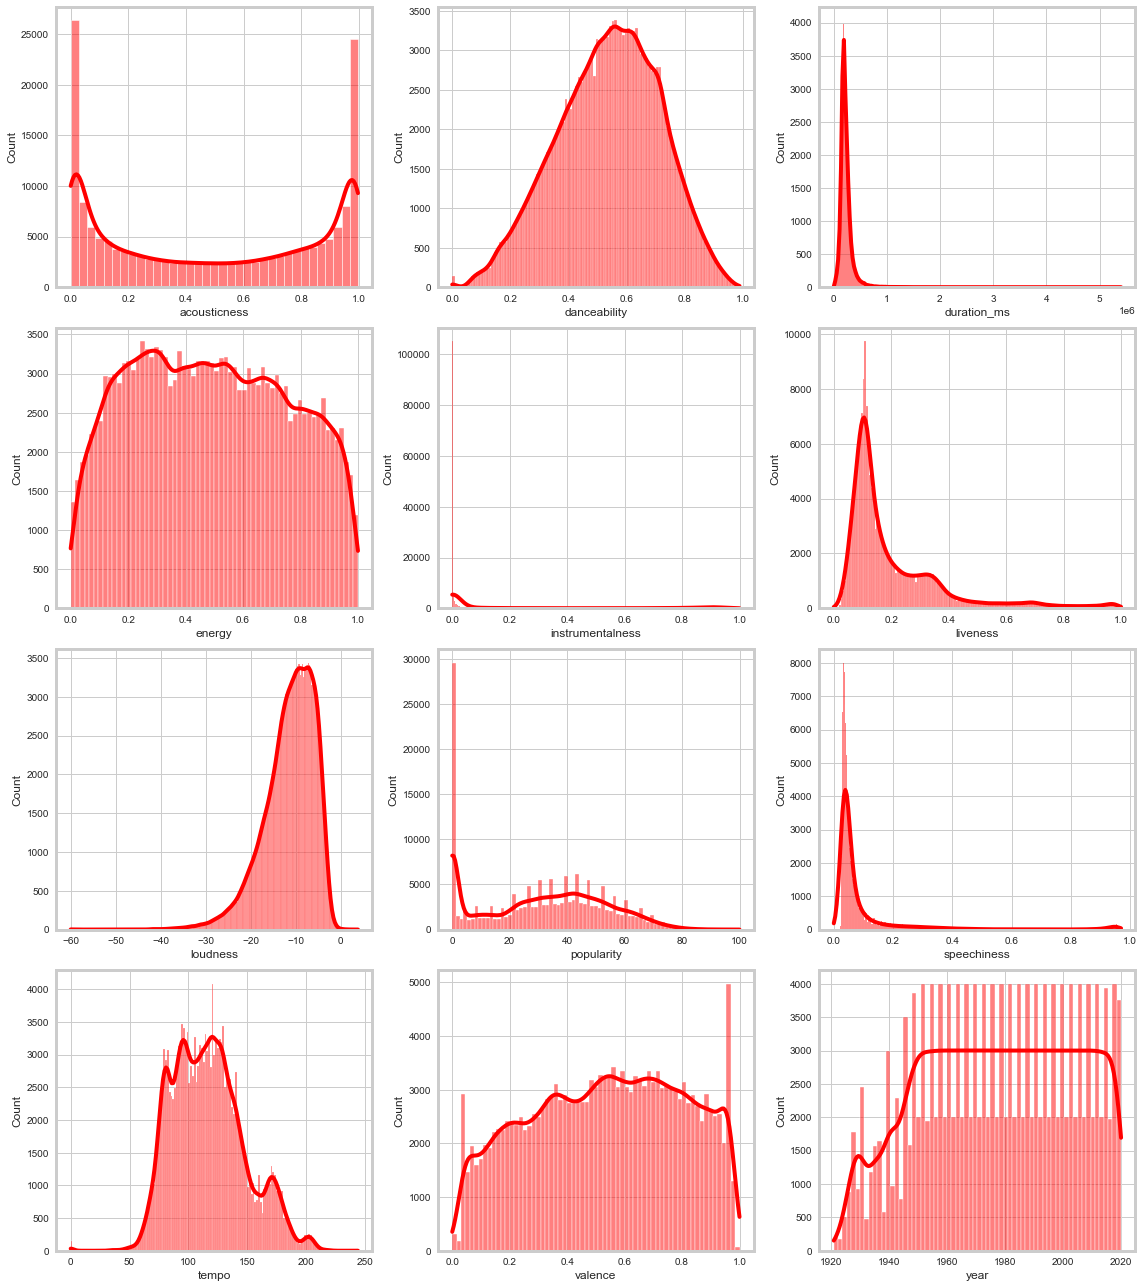

In [17]:
#Displaying distribution of NUmerical variables
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(16,18))
axs = np.ravel(axs)

numerical_cols = data.select_dtypes('number').columns.to_list()
for i, col in enumerate(numerical_cols):
    plt.sca(axs[i])
    sns.histplot(data=data, x=col, kde=True, fill=True, color='red')

plt.tight_layout()
plt.show()

In [18]:
#Splitting data by years for EDA
df_1950 = data[data['year']<1950]
df_2000 = data[(data['year']>=1950) & (data['year']<2000)]
df_2019 = data[(data['year']>=2000) & (data['year']<2020)]
df_2020 = data[data['year']>=2020]

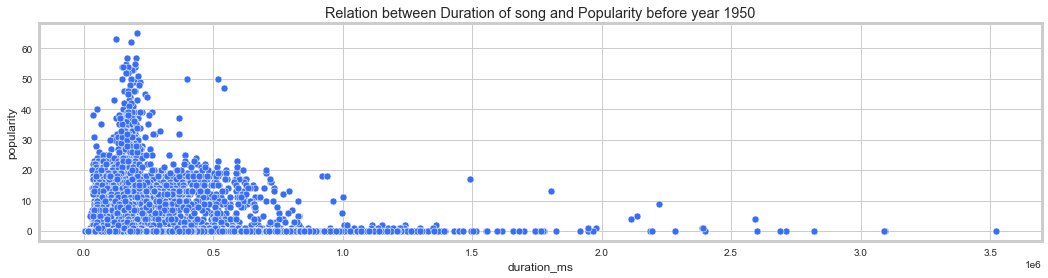

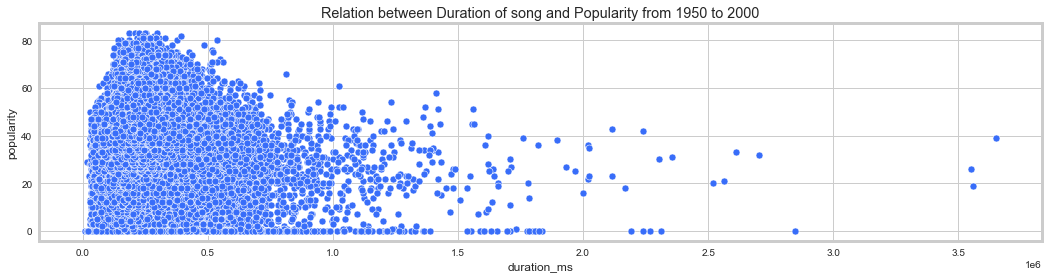

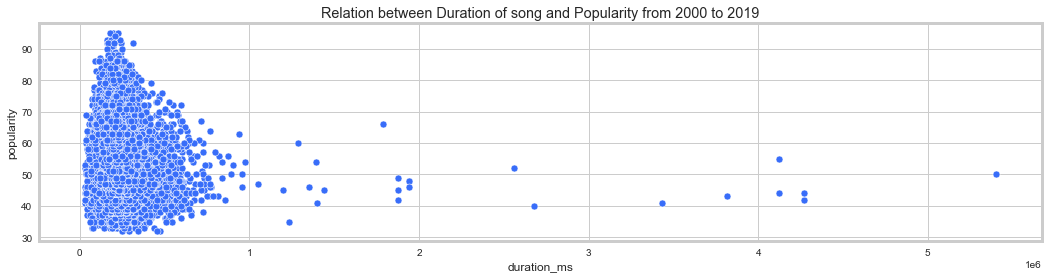

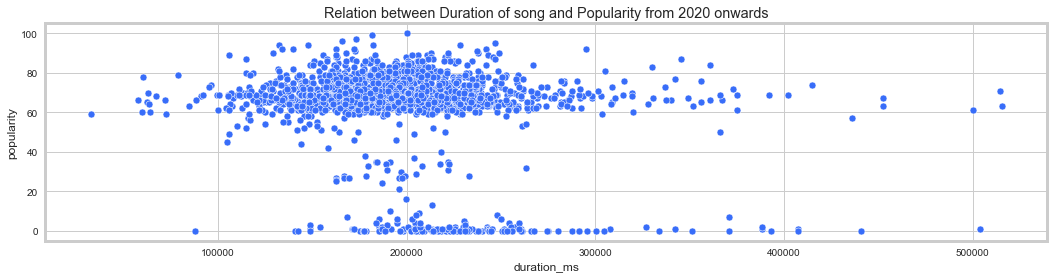

In [19]:
plt.figure(figsize=(16,4))

sns.scatterplot(x=df_1950['duration_ms'], y=df_1950['popularity'])
plt.title("Relation between Duration of song and Popularity before year 1950")
#plt.show()

plt.figure(figsize=(16,4))
sns.scatterplot(x=df_2000['duration_ms'], y=df_2000['popularity'])
plt.title("Relation between Duration of song and Popularity from 1950 to 2000")
#plt.show()

plt.figure(figsize=(16,4))
sns.scatterplot(x=df_2019['duration_ms'], y=df_2019['popularity'])
plt.title("Relation between Duration of song and Popularity from 2000 to 2019")
#plt.show()


plt.figure(figsize=(16,4))
sns.scatterplot(x=df_2020['duration_ms'], y=df_2020['popularity'])
plt.title("Relation between Duration of song and Popularity from 2020 onwards")

#plt.tight_layout()
plt.show()

In [20]:
#Checking Skew for Numerical variables
data[num_cols].skew()

acousticness        0.008720
danceability       -0.212896
duration_ms         6.489527
energy              0.077368
instrumentalness    1.681509
liveness            2.145796
loudness           -1.071208
popularity         -0.021527
speechiness         4.235813
tempo               0.448567
valence            -0.124010
year               -0.132748
dtype: float64

In [21]:
#Transforming Data to reduce Skew
#Power transforming the raw data
pt = PowerTransformer(method='yeo-johnson', standardize=True)
df_num_pt = pd.DataFrame(pt.fit_transform(data[num_cols]), columns=data[num_cols].columns, index=data[num_cols].index)

#Checking skew after transformation
skew = pd.DataFrame(columns=['Variable','skew'])
for i in df_num_pt.columns:
    skew.loc[len(skew.index)] = [i, df_num_pt[i].skew()]
skew

,Variable,skew
0,acousticness,-0.068277
1,danceability,-0.034222
2,duration_ms,0.020586
3,energy,-0.035967
4,instrumentalness,1.163562
5,liveness,0.327066
6,loudness,0.010805
7,popularity,-0.469333
8,speechiness,0.950062
9,tempo,0.087510


In [22]:
#Skew has been successfully reduced, this is needed since we'll build linear models

In [23]:
#Transformed numerical data
df_num_pt

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,popularity,speechiness,tempo,valence,year
0,1.284455,0.973805,-0.695583,-1.106425,1.812808,-0.052100,-0.359097,-1.672833,-0.164144,0.101307,0.941482,-1.835824
1,1.282194,-0.921882,0.688576,-1.882441,1.889861,-1.108851,-2.292763,-1.672833,-0.317419,-1.088774,-1.703614,-1.835824
2,0.351054,1.228984,-1.684612,-1.003927,-0.630486,-0.445473,-1.410000,-1.672833,2.212289,-0.271135,1.341203,-1.835824
3,1.284455,1.430989,-0.384577,-1.377647,1.888500,-0.556555,-0.722918,-1.672833,0.886779,-0.243385,0.709991,-1.835824
4,1.273145,-1.786448,2.893131,-1.069413,1.890511,-0.749366,-1.018925,-1.549305,-0.458290,-1.943365,-1.730028,-1.835824
...,...,...,...,...,...,...,...,...,...,...,...,...
169904,-0.826245,2.038636,-0.619557,-0.129249,-0.629892,-0.890805,0.631944,1.633406,1.535188,-0.515460,-0.868597,1.744496
169905,-1.307385,1.041865,-0.566817,-0.350362,-0.123660,-0.556555,-0.091424,1.297998,-0.539711,0.404948,-1.001719,1.744496
169906,0.182369,-0.177236,-0.385370,0.227919,-0.588164,-0.599662,0.215554,1.483285,1.091861,0.269096,-1.429248,1.744496
169907,-1.134942,0.595756,-0.569094,1.016489,-0.630486,0.593262,2.241287,1.483285,-0.611609,0.464904,-0.245776,1.744496


In [24]:
#Checking for correlation
df_num_pt.corr()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,popularity,speechiness,tempo,valence,year
acousticness,1.000000,-0.258503,-0.170043,-0.748994,0.306541,0.009217,-0.585264,-0.601271,-0.113643,-0.210158,-0.176710,-0.613956
danceability,-0.258503,1.000000,-0.086621,0.227516,-0.271055,-0.121927,0.259946,0.210898,0.284968,0.014133,0.551702,0.210133
duration_ms,-0.170043,-0.086621,1.000000,0.122255,0.052773,-0.046907,0.086907,0.185608,-0.095623,0.006144,-0.186203,0.177565
energy,-0.748994,0.227516,0.122255,1.000000,-0.269771,0.087514,0.807454,0.514306,0.137431,0.260516,0.358632,0.530073
instrumentalness,0.306541,-0.271055,0.052773,-0.269771,1.000000,-0.036269,-0.366968,-0.323702,-0.100240,-0.100752,-0.177949,-0.303178
liveness,0.009217,-0.121927,-0.046907,0.087514,-0.036269,1.000000,0.046291,-0.107563,0.132450,-0.000453,-0.011035,-0.087716
loudness,-0.585264,0.259946,0.086907,0.807454,-0.366968,0.046291,1.000000,0.488489,0.092767,0.214286,0.269793,0.534894
popularity,-0.601271,0.210898,0.185608,0.514306,-0.323702,-0.107563,0.488489,1.000000,-0.064662,0.147720,0.020135,0.878623
speechiness,-0.113643,0.284968,-0.095623,0.137431,-0.100240,0.132450,0.092767,-0.064662,1.000000,0.082318,0.131396,0.007857
tempo,-0.210158,0.014133,0.006144,0.260516,-0.100752,-0.000453,0.214286,0.147720,0.082318,1.000000,0.180573,0.138971


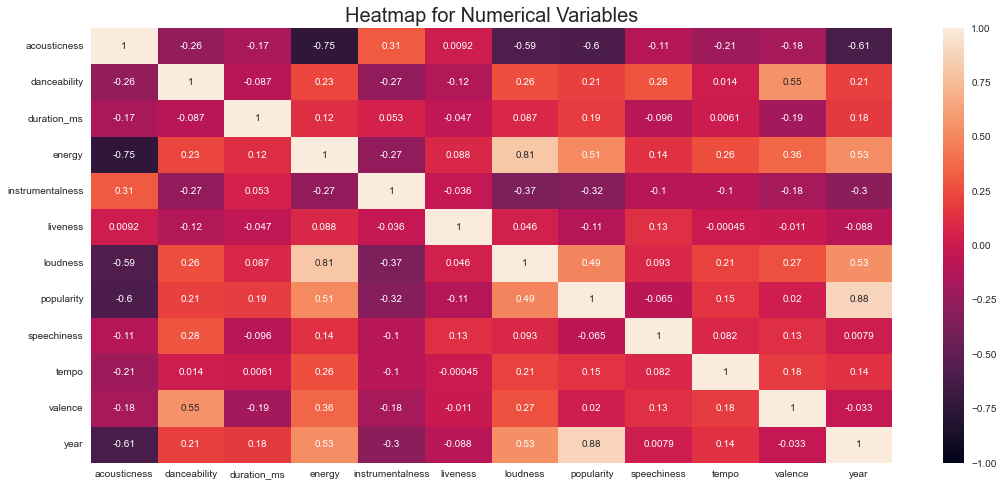

In [28]:
#Heatmap for correlation
plt.figure(figsize=(16,8))
sns.heatmap(df_num_pt.corr(), annot=True, vmax=1, vmin=-1)
plt.title("Heatmap for Numerical Variables",fontdict={'fontsize':20})
plt.show()

In [29]:
#No visible multicollinearity, cheking VIF just to be sure
vif_data = pd.DataFrame()
vif_data["feature"] = df_num_pt.columns
  
#Calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(df_num_pt.values, i) for i in range(len(df_num_pt.columns))]
vif_data

,feature,VIF
0,acousticness,2.929021
1,danceability,1.916783
2,duration_ms,1.116869
3,energy,5.373507
4,instrumentalness,1.292138
5,liveness,1.093536
6,loudness,3.369192
7,popularity,4.815591
8,speechiness,1.214077
9,tempo,1.118318


In [30]:
# No heavy multicollinearity, Year is the only one having a high VIF value, but since the highest correlation of year
# is with the target, we will keep this columns.

In [31]:
#Meadian song attributes for each year
df_med = data[["danceability","acousticness","energy","speechiness","instrumentalness","valence"]].groupby(data.year).mean()
df_med

,danceability,acousticness,energy,speechiness,instrumentalness,valence
year,,,,,,
1921,0.425661,0.895823,0.236784,0.077258,0.322330,0.425495
1922,0.480000,0.939236,0.237026,0.115419,0.440470,0.534056
1923,0.568462,0.976329,0.246936,0.098619,0.401932,0.624788
1924,0.548654,0.935575,0.347033,0.090210,0.583955,0.668574
1925,0.571890,0.965422,0.264373,0.115457,0.408893,0.616430
...,...,...,...,...,...,...
2016,0.599976,0.280290,0.592877,0.107298,0.074646,0.430769
2017,0.612286,0.289916,0.586739,0.111752,0.098209,0.414465
2018,0.664930,0.271941,0.590591,0.128140,0.035948,0.447141


Text(0, 0.5, 'Density')

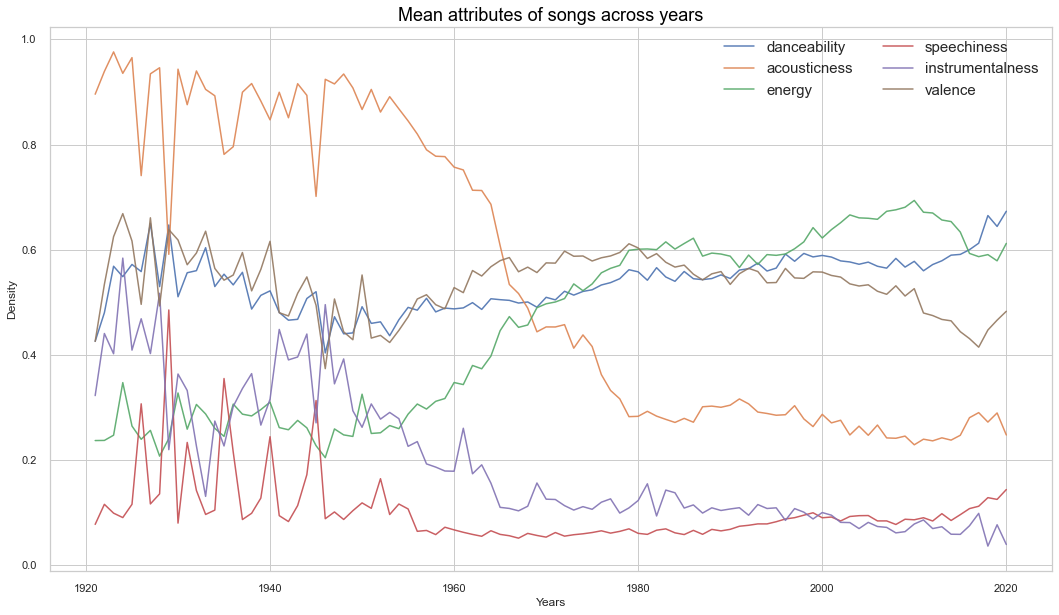

In [32]:
plt.figure(figsize=(16, 10))
sns.set(style="whitegrid")
 
# create a color palette
palette = plt.get_cmap('seismic')

# multiple line plot
num=0
for i in df_med.columns:
    plt.plot(df_med[i], linewidth= 1.5, alpha=0.9,label = i)


# Add legend
plt.legend(loc = 'upper right', ncol = 2,fontsize= 15)
 
# Add titles
plt.title("Mean attributes of songs across years", fontsize=18, fontweight=0, color='black')
plt.xlabel("Years")
plt.ylabel("Density")

In [33]:
data.groupby('explicit')[['popularity']].median()

,popularity
explicit,
0,32.0
1,52.0


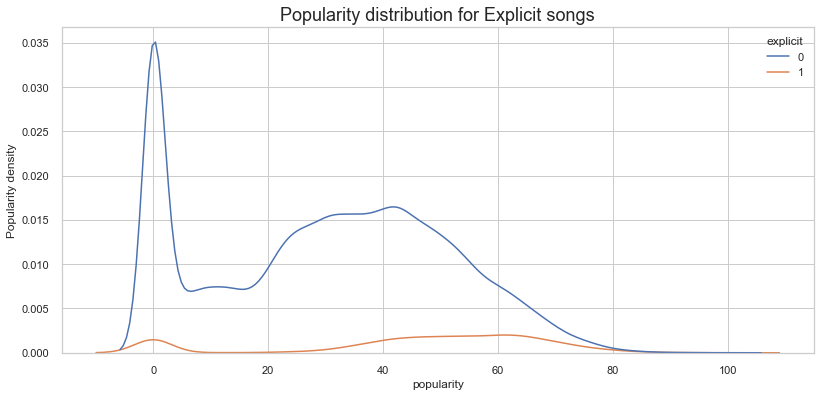

In [34]:
plt.figure(figsize=(12,6))
sns.kdeplot(data.popularity, hue=data.explicit)
plt.ylabel("Popularity density")
plt.title("Popularity distribution for Explicit songs", fontdict={'fontsize':18,'fontweight':5})
plt.show()

In [35]:
data.groupby('key')[['popularity']].median()

,popularity
key,
0,32.0
1,39.0
2,34.0
3,22.0
4,35.0
5,29.0
6,38.0
7,33.0
8,32.0


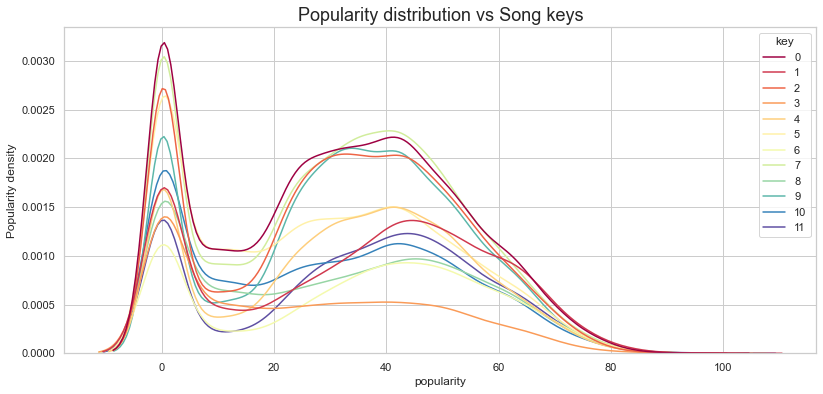

In [31]:
plt.figure(figsize=(12,6))
sns.kdeplot(data.popularity, hue=data.key, palette='Spectral')
plt.ylabel("Popularity density")
plt.title("Popularity distribution vs Song keys", fontdict={'fontsize':18,'fontweight':5})
plt.show()

In [32]:
data.groupby('mode')[['popularity']].median()

,popularity
mode,
0,35.0
1,33.0


In [33]:
# Explicit afftects popularity, for other categorical we can't say anything for sure, we need to build models and check 
# important features

In [34]:
#Scaling numeric variables
sc = StandardScaler()
df_num_sc = pd.DataFrame(sc.fit_transform(df_num_pt), columns=df_num_pt.columns, index=df_num_pt.index)
df_num_sc

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,popularity,speechiness,tempo,valence,year
0,1.284455,0.973805,-0.695583,-1.106425,1.812808,-0.052100,-0.359097,-1.672833,-0.164144,0.101307,0.941482,-1.835824
1,1.282194,-0.921882,0.688576,-1.882441,1.889861,-1.108851,-2.292763,-1.672833,-0.317419,-1.088774,-1.703614,-1.835824
2,0.351054,1.228984,-1.684612,-1.003927,-0.630486,-0.445473,-1.410000,-1.672833,2.212289,-0.271135,1.341203,-1.835824
3,1.284455,1.430989,-0.384577,-1.377647,1.888500,-0.556555,-0.722918,-1.672833,0.886779,-0.243385,0.709991,-1.835824
4,1.273145,-1.786448,2.893131,-1.069413,1.890511,-0.749366,-1.018925,-1.549305,-0.458290,-1.943365,-1.730028,-1.835824
...,...,...,...,...,...,...,...,...,...,...,...,...
169904,-0.826245,2.038636,-0.619557,-0.129249,-0.629892,-0.890805,0.631944,1.633406,1.535188,-0.515460,-0.868597,1.744496
169905,-1.307385,1.041865,-0.566817,-0.350362,-0.123660,-0.556555,-0.091424,1.297998,-0.539711,0.404948,-1.001719,1.744496
169906,0.182369,-0.177236,-0.385370,0.227919,-0.588164,-0.599662,0.215554,1.483285,1.091861,0.269096,-1.429248,1.744496
169907,-1.134942,0.595756,-0.569094,1.016489,-0.630486,0.593262,2.241287,1.483285,-0.611609,0.464904,-0.245776,1.744496


In [36]:
#Categorical Variables
df_cat = data[cat_cols]
df_cat

,explicit,key,mode
0,0,10,1
1,0,8,1
2,0,5,0
3,0,1,0
4,0,11,1
...,...,...,...
169904,1,1,1
169905,0,8,1
169906,0,7,1
169907,0,1,1


### Train test split

In [37]:
#Encoding categorical variables
df_cat_enc = pd.get_dummies(df_cat, drop_first=True)
df_cat_enc

,explicit_1,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,mode_1
0,0,0,0,0,0,0,0,0,0,0,1,0,1
1,0,0,0,0,0,0,0,0,1,0,0,0,1
2,0,0,0,0,0,1,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
169904,1,1,0,0,0,0,0,0,0,0,0,0,1
169905,0,0,0,0,0,0,0,0,1,0,0,0,1
169906,0,0,0,0,0,0,0,1,0,0,0,0,1
169907,0,1,0,0,0,0,0,0,0,0,0,0,1


In [38]:
#Final dataframe combining scaled numeric and encoded categorical variables
df_final = pd.concat([df_num_sc,df_cat_enc],axis=1)
df_final

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,popularity,speechiness,tempo,...,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,mode_1
0,1.284455,0.973805,-0.695583,-1.106425,1.812808,-0.052100,-0.359097,-1.672833,-0.164144,0.101307,...,0,0,0,0,0,0,0,1,0,1
1,1.282194,-0.921882,0.688576,-1.882441,1.889861,-1.108851,-2.292763,-1.672833,-0.317419,-1.088774,...,0,0,0,0,0,1,0,0,0,1
2,0.351054,1.228984,-1.684612,-1.003927,-0.630486,-0.445473,-1.410000,-1.672833,2.212289,-0.271135,...,0,0,1,0,0,0,0,0,0,0
3,1.284455,1.430989,-0.384577,-1.377647,1.888500,-0.556555,-0.722918,-1.672833,0.886779,-0.243385,...,0,0,0,0,0,0,0,0,0,0
4,1.273145,-1.786448,2.893131,-1.069413,1.890511,-0.749366,-1.018925,-1.549305,-0.458290,-1.943365,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169904,-0.826245,2.038636,-0.619557,-0.129249,-0.629892,-0.890805,0.631944,1.633406,1.535188,-0.515460,...,0,0,0,0,0,0,0,0,0,1
169905,-1.307385,1.041865,-0.566817,-0.350362,-0.123660,-0.556555,-0.091424,1.297998,-0.539711,0.404948,...,0,0,0,0,0,1,0,0,0,1
169906,0.182369,-0.177236,-0.385370,0.227919,-0.588164,-0.599662,0.215554,1.483285,1.091861,0.269096,...,0,0,0,0,1,0,0,0,0,1
169907,-1.134942,0.595756,-0.569094,1.016489,-0.630486,0.593262,2.241287,1.483285,-0.611609,0.464904,...,0,0,0,0,0,0,0,0,0,1


In [39]:
#Saving to local disk
df_final.to_csv('df_final.csv')

In [41]:
#Train Test Split
X = df_final.drop(columns='popularity')
y = df_final['popularity']

xtrain, xtest, ytrain, ytest = train_test_split(X,y, train_size=0.7, random_state=10)

print(xtrain.shape)
print(xtest.shape)
print(ytrain.shape)
print(ytest.shape)

(118936, 24)
(50973, 24)
(118936,)
(50973,)


### Modelling

In [70]:
###KNN MODELLING
knn = KNeighborsRegressor(n_neighbors=5,weights='distance')
knn_model = knn.fit(xtrain, ytrain)

In [71]:
#predicting
knn_pred = knn_model.predict(xtest)

In [74]:
#Retreiving R2 score for Knn Model
print("KNN Model R2 Score:", metrics.r2_score(ytest,knn_pred))

KNN Model R2 Score: 0.7815436184093992


In [73]:
print("KNN Model RMSE value:", metrics.mean_squared_error(ytest, knn_pred, squared=False))

KNN Model RMSE value: 0.46703954063220493


In [48]:
###RANDOM FOREST MODELLING

In [49]:
#Fitting RF Model
rf = RandomForestRegressor()
rf_model = rf.fit(xtrain, ytrain)

In [50]:
#Predicting
rf_pred = rf_model.predict(xtest)

In [51]:
#R2 score for RF Model
metrics.r2_score(ytest,rf_pred)

0.8660726693402738

In [52]:
#RMSE for RF Model
metrics.mean_squared_error(ytest, rf_pred, squared=False)

0.3656839411991017

In [53]:
#Checking Feature Importance
rf_model.feature_importances_

array([1.33972195e-02, 1.28260497e-02, 1.48052717e-02, 1.22818025e-02,
       1.02811561e-02, 1.30424078e-02, 1.32185466e-02, 1.35087830e-02,
       1.26193093e-02, 1.16767225e-02, 8.61017718e-01, 1.19607489e-03,
       8.14095059e-04, 9.15979630e-04, 6.17203240e-04, 8.28848457e-04,
       8.94600015e-04, 6.30672796e-04, 9.73465534e-04, 7.57468011e-04,
       9.55845393e-04, 8.11069165e-04, 7.21649577e-04, 1.20804201e-03])

In [54]:
#Feature Importance dataframe
imp = pd.DataFrame({'variables':xtrain.columns, 'importance':rf_model.feature_importances_})
imp = imp.sort_values(by='importance',ascending=False)
imp

,variables,importance
10,year,0.861018
2,duration_ms,0.014805
7,speechiness,0.013509
0,acousticness,0.013397
6,loudness,0.013219
5,liveness,0.013042
1,danceability,0.012826
8,tempo,0.012619
3,energy,0.012282
9,valence,0.011677


<AxesSubplot:xlabel='importance', ylabel='variables'>

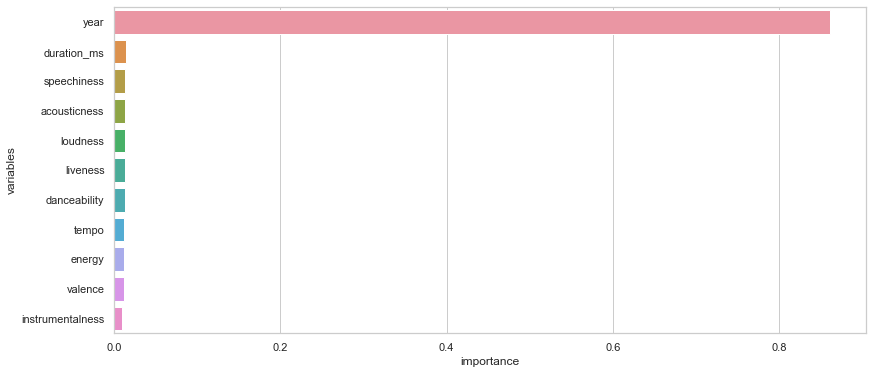

In [55]:
#Plotting Important Features
plt.figure(figsize=(12,6))
sns.barplot(x=imp.iloc[0:11]['importance'], y=imp.iloc[0:11]['variables'])

In [ ]:
#Year seems to be the most important feature, this actually makes sense as newer songs are much more popular than ones released 
#from 1950-2000

<AxesSubplot:xlabel='importance', ylabel='variables'>

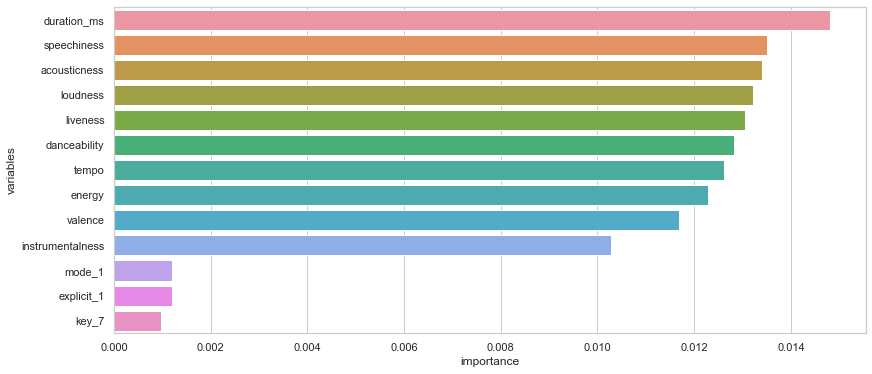

In [56]:
#Important Features other than Year
plt.figure(figsize=(12,6))
sns.barplot(x=imp.iloc[1:14]['importance'], y=imp.iloc[1:14]['variables'])

In [57]:
###GRADIENT BOOSTING REGRESSOR MODEL

In [58]:
#Fitting GB Model
gb = GradientBoostingRegressor()
gb_model = gb.fit(xtrain, ytrain)

In [59]:
#Prediction
gb_pred = gb_model.predict(xtest)

In [60]:
#Getting R2 score
metrics.r2_score(ytest, gb_pred)

0.8602436024916714

In [61]:
#Getting RMSE value
metrics.mean_squared_error(ytest, gb_pred, squared=False)

0.3735572169481276

In [62]:
#Retreiving Feature importance
gb_model.feature_importances_

array([1.78604623e-03, 8.40859292e-04, 1.74084774e-03, 5.00609814e-04,
       1.12870336e-03, 7.17915519e-04, 1.10864684e-03, 1.70353204e-03,
       4.40164726e-05, 7.50905055e-05, 9.89729387e-01, 5.82997474e-04,
       0.00000000e+00, 3.03484594e-06, 1.12080985e-05, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.71050768e-05])

In [63]:
imp = pd.DataFrame({'variables':xtrain.columns, 'importance':gb_model.feature_importances_})
imp = imp.sort_values(by='importance',ascending=False)
imp

,variables,importance
10,year,0.989729
0,acousticness,0.001786
2,duration_ms,0.001741
7,speechiness,0.001704
4,instrumentalness,0.001129
6,loudness,0.001109
1,danceability,0.000841
5,liveness,0.000718
11,explicit_1,0.000583
3,energy,0.000501


<AxesSubplot:xlabel='importance', ylabel='variables'>

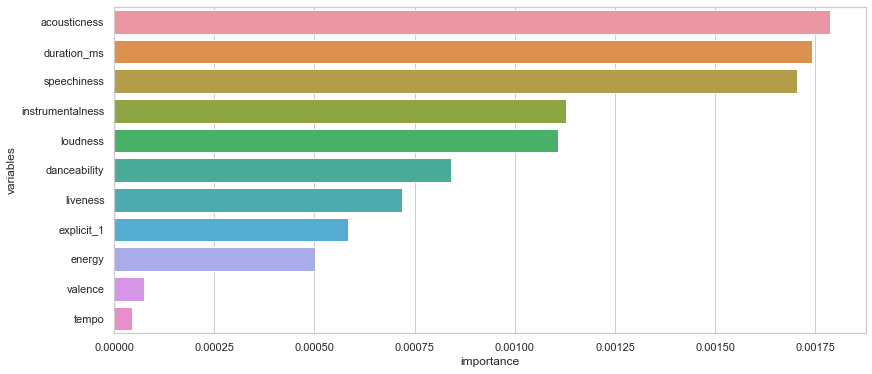

In [65]:
#Plotting important features other than 'year'
plt.figure(figsize=(12,6))
sns.barplot(x=imp.iloc[1:12]['importance'], y=imp.iloc[1:12]['variables'])

In [66]:
#getting closest neighbour of a record with KNN model
knn_model.kneighbors(xtrain.iloc[0:1,:],n_neighbors=2)

(array([[0.        , 1.00642179]]), array([[    0, 81041]], dtype=int64))

In [67]:
xtrain.iloc[0:1,:]

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,...,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,mode_1
40142,-0.915916,1.348625,-0.454736,0.322871,-0.630486,0.940932,0.694873,-0.101049,0.463343,-0.864889,...,0,1,0,0,0,0,0,0,0,0


In [68]:
r2 = [metrics.r2_score(ytest,knn_pred),metrics.r2_score(ytest,rf_pred),metrics.r2_score(ytest,gb_pred)]
rmse = [metrics.mean_squared_error(ytest,knn_pred, squared=False),metrics.mean_squared_error(ytest,rf_pred,squared=False),metrics.mean_squared_error(ytest,gb_pred,squared=False)]
mape = [metrics.mean_absolute_percentage_error(ytest,knn_pred),metrics.mean_absolute_percentage_error(ytest,rf_pred),metrics.mean_absolute_percentage_error(ytest,gb_pred)]

perf = pd.DataFrame({'Model':['KNN Regressor','Random Forest Regressor','Gradient Boost Regressor'],
                    'R2 Score':r2, 'RMSE':rmse, 'MAPE':mape})
perf

,Model,R2 Score,RMSE,MAPE
0,KNN Regressor,0.781544,0.467040,1.471547
1,Random Forest Regressor,0.866073,0.365684,1.188364
2,Gradient Boost Regressor,0.860244,0.373557,1.194587


In [ ]:
#For the 3 models the above tables displays the variable metrics
#Random Forest Regressor seems to be the best model since it has the highes R2 score and lowest RMSE
#So we can refer the important features of RF model to check the different atrributes which makes a song popular/trending.  

### Clustering

In [69]:
#Installing Plotly to Plot Interactive plots for clustering
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [70]:
import plotly.express as px 

In [71]:
z#creating pipelines for scaling/clustering
cluster_pipeline = Pipeline([('scaler', StandardScaler()), ('kmeans', KMeans(n_clusters=10))])
X = data_gr.select_dtypes(np.number)
cluster_pipeline.fit(X)
data_gr['cluster'] = cluster_pipeline.predict(X)

In [ ]:
#Clustering Genres using the genre database

from sklearn.manifold import TSNE

#Using t-Stochastic clustering
pipeline_tsne = Pipeline([('scaler', StandardScaler()), ('tsne', TSNE(n_components=2, verbose=1))])
genre_new = pipeline_tsne.fit_transform(X)
results = pd.DataFrame(columns=['x', 'y'], data=genre_new)
results['genres'] = data_gr['genres'] #overwriting main genres
results['cluster'] = data_gr['cluster']

#plotting cluster
fig = px.scatter(results, x='x', y='y', color='cluster', hover_data=['x', 'y', 'genres'])
fig.show()
fig.write_image('genre_clusters.png')

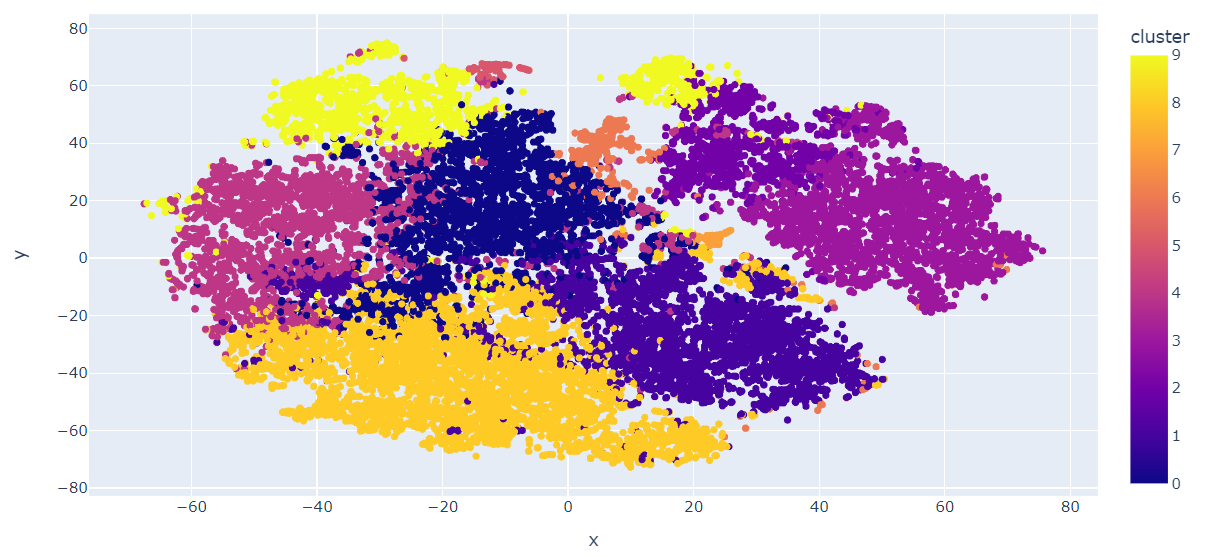

In [52]:
#Displaying Plotly plot generated in previous cell, in case that plot is not visible or takes long to load
from PIL import Image
img_genres = Image.open("genre_clusters.png");
img_genres

In [47]:
# Clustering Songs

#Creating Pipeline for scaling and clustering
pipeline_song_cluster = Pipeline([('scaler', StandardScaler()), 
                                  ('kmeans', KMeans(n_clusters=10, 
                                   verbose=False))], verbose=False)

X = data.select_dtypes(np.number)
num_cols = list(X.columns)
pipeline_song_cluster.fit(X)
labels_song_clust = pipeline_song_cluster.predict(X)
data['labels_cluster'] = labels_song_clust

In [48]:
#Displaying Song cluster labels
data['labels_cluster']

0         5
1         3
2         6
3         5
4         2
         ..
169904    0
169905    7
169906    7
169907    7
169908    7
Name: labels_cluster, Length: 169909, dtype: int32

In [ ]:
#Dimensionality Reduction with PCA

from sklearn.decomposition import PCA

#Implementing PCA
pipeline_PCA = Pipeline([('scaler', StandardScaler()), ('PCA', PCA(n_components=2))])
song_insertion = pipeline_PCA.fit_transform(X)
pca_data = pd.DataFrame(columns=['x', 'y'], data=song_insertion)
pca_data['title'] = data['name']
pca_data['cluster'] = data['labels_cluster']

#Plotting Inetractive plot after PCA
fig = px.scatter(pca_data, x='x', y='y', color='cluster', hover_data=['x', 'y', 'title'])
fig.show()
fig.write_image('song_clusters.png')

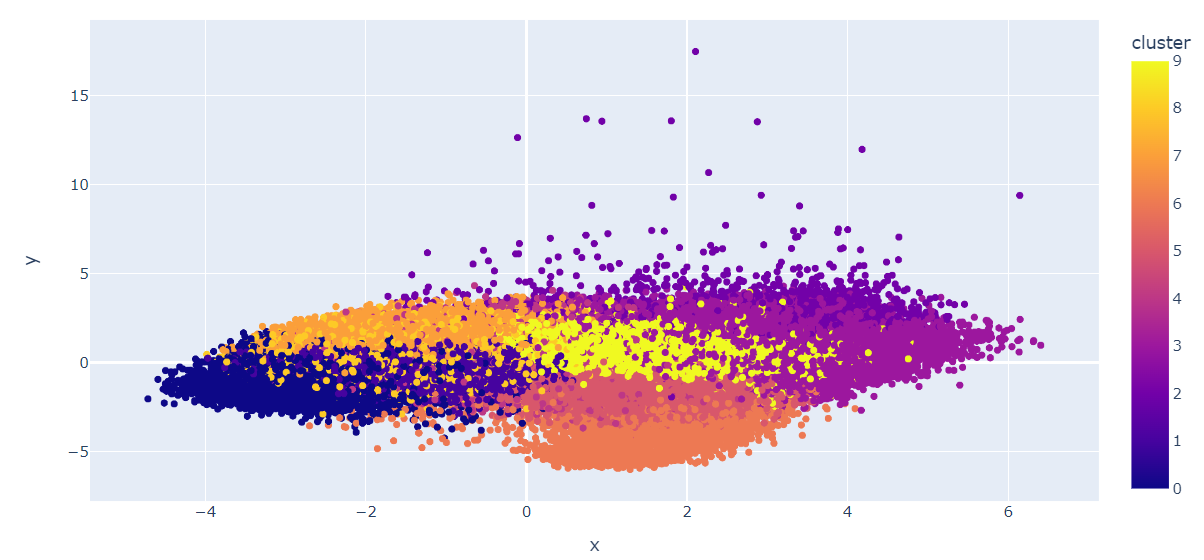

In [51]:
#Displaying Plotly plot generated in previous cell, in case that plot is not visible or takes long to load
img_songs = Image.open("song_clusters.png");
img_songs

For (k= 2 ) the silhouette score is : 0.4561698790255063
Silhouette Plot:


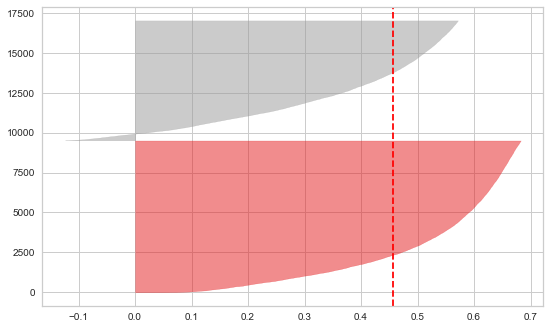

For (k= 4 ) the silhouette score is : 0.3566826381154165
Silhouette Plot:


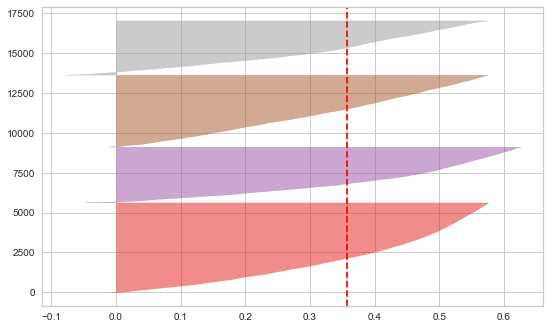

For (k= 8 ) the silhouette score is : 0.34801178169270613
Silhouette Plot:


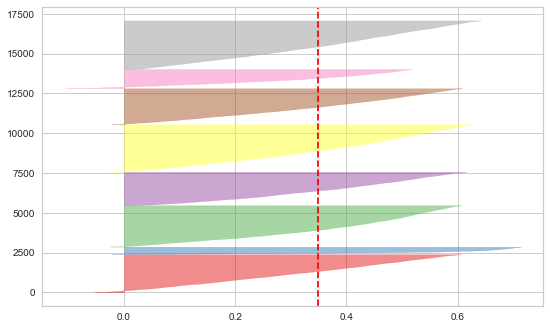

For (k= 10 ) the silhouette score is : 0.33531220333219064
Silhouette Plot:


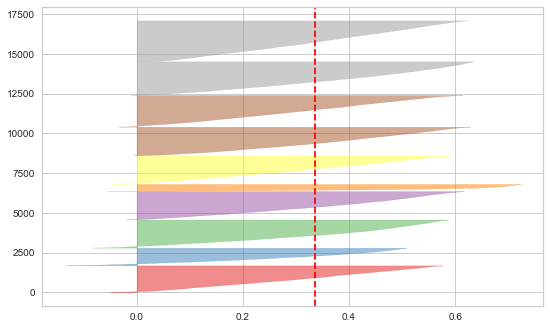

In [53]:
#Using Silhouette Score and Visualizations to Determines best number of clusters
from yellowbrick.cluster import SilhouetteVisualizer

X2 = pca_data[['x','y']].iloc[0:17000,:]

for i in [2, 4, 8, 10]:
    km = KMeans(n_clusters=i)
    kmodel = km.fit(X2)
    score = metrics.silhouette_score(X2, kmodel.labels_, metric='euclidean')
    print("For (k=",i,") the silhouette score is :",score)
    print("Silhouette Plot:")
    visualizer = SilhouetteVisualizer(km)
    visualizer.fit(X2) 
    plt.show()

In [ ]:
#Even though 2 clusters give the best Silhouette score, this won't be useful for clustering songs
#There are various genres in songs so the two polar opposite ones w.r.t song attributes will become the 2 clusters
#Therefore, we go ahead with 10 clusters for Songs which we made earlier for our reccomendation system

### Reccomendation

In [54]:
#Implememting Reccomendation system using the clusters formed earlier and the various song attributes

In [63]:
from collections import defaultdict
from sklearn.metrics import euclidean_distances
from scipy.spatial.distance import cdist
import difflib

num_cols = ['acousticness', 'danceability',  'explicit','speechiness', 'tempo', 'instrumentalness', 'key', 'liveness', 
            'loudness', 'valence', 'year','mode', 'popularity', 'duration_ms', 'energy']

def get_song(name, year):
    song_info = defaultdict()
    found = sp.search(q= 'track: {} year: {}'.format(name,year), limit=1)
    if found['tracks']['items'] == []:
        return None

    found = found['tracks']['items'][0]
    track_id = found['id']
    audio_features = sp.audio_features(track_id)[0]

    song_info['name'] = [name]
    song_info['year'] = [year]
    song_info['explicit'] = [int(found['explicit'])]
    song_info['duration_ms'] = [found['duration_ms']]
    song_info['popularity'] = [found['popularity']]

    for key, value in audio_features.items():
        song_info[key] = value

    return pd.DataFrame(song_info)


def get_song_info(song, spotify_data):    
    try:
        song_info = spotify_data[(spotify_data['name'] == song['name']) & (spotify_data['year'] == song['year'])].iloc[0]
        return song_info
    
    except IndexError:
        return get_song(song['name'], song['year'])
        

def dict_flatten(dict_list):   
    flat_dict = defaultdict()
    for key in dict_list[0].keys():
        flat_dict[key] = []
    
    for dictionary in dict_list:
        for key, value in dictionary.items():
            flat_dict[key].append(value)
            
    return flat_dict


def mean_vector(song_list, spotify_data):   
    vectors = []
    
    for song in song_list:
        song_info = get_song_info(song, spotify_data)
        if song_info is None:
            print('Warning: {} does not exist in Spotify or in database'.format(song['name']))
            continue
        vector = song_info[num_cols].values
        vectors.append(vector)  
    
    matrix = np.array(list(vectors))
    return np.mean(matrix, axis=0)


#Final function to retreive the closest match using earlier function and returns the finds
def song_recommendation(song_list, spotify_data, n_songs=10):    
    metadata_col = ['name', 'year', 'artists']
    dict_song = dict_flatten(song_list)
    
    center_song = mean_vector(song_list, spotify_data)
    scaler = pipeline_song_cluster.steps[0][1]
    scaled_data = scaler.transform(spotify_data[num_cols])
    scaled_center_song = scaler.transform(center_song.reshape(1, -1))
    distances = cdist(scaled_center_song, scaled_data, 'cosine')
    index = list(np.argsort(distances)[:, :n_songs][0])
    
    songs_rec = spotify_data.iloc[index]
    songs_rec = songs_rec[~songs_rec['name'].isin(dict_song['name'])]
    return songs_rec[metadata_col].to_dict(orient='records')

In [64]:
#Calling recommendation system function
#Passing song name and year to uniquely indetify a song
song_recommendation([{'name': 'Blinding Lights', 'year':2020}],  data)

[{'name': 'Acapella', 'year': 2014, 'artists': "['Karmin']"},
 {'name': 'Oh My God', 'year': 2008, 'artists': "['Ida Maria']"},
 {'name': 'Collar Full', 'year': 2013, 'artists': "['Panic! At The Disco']"},
 {'name': "What's Your Name", 'year': 2014, 'artists': "['Chase Rice']"},
 {'name': 'Juicy', 'year': 2019, 'artists': "['Doja Cat']"},
 {'name': "Listen to D.J.'s",
  'year': 2001,
  'artists': "['Long Beach Dub Allstars']"},
 {'name': 'Bježi Kišo S Prozora',
  'year': 1986,
  'artists': "['Crvena Jabuka']"},
 {'name': "I'd Do Anything", 'year': 2018, 'artists': "['Simple Plan']"}]

In [65]:
#If 2 songs are passed, the closest match to both will be retreived
song_recommendation([{'name': 'Say So', 'year':2019},
                     {'name': "Don't Start Now", 'year':2019}],  data)

[{'name': 'Home',
  'year': 2018,
  'artists': "['Vince Staples', 'Richie Kohan']"},
 {'name': 'Oscillate Wildly - 2011 Remaster',
  'year': 1987,
  'artists': "['The Smiths']"},
 {'name': 'New Rules', 'year': 2017, 'artists': "['Dua Lipa']"},
 {'name': 'Ocean Drive', 'year': 2015, 'artists': "['Duke Dumont']"},
 {'name': 'beibs in the trap', 'year': 2016, 'artists': "['Travis Scott']"},
 {'name': 'New Rules', 'year': 2017, 'artists': "['Dua Lipa']"},
 {'name': 'Glycerine - Acoustic', 'year': 2005, 'artists': "['Bush']"},
 {'name': 'Highway to Hell', 'year': 1979, 'artists': "['AC/DC']"},
 {'name': 'Smack That', 'year': 2006, 'artists': "['Akon', 'Eminem']"},
 {'name': 'Fairly Local', 'year': 2015, 'artists': "['Twenty One Pilots']"}]

In [ ]:
#-------------------------------------------------------- END -----------------------------------------------------------------